#  Business Case: Scaler - Clustering

## About the Dataset
* We are provided with the information for a segment of learners by Scaler, an online tech-versity.
* Working as a data scientist with the analytics vertical of Scaler, we got this dataset from the Scaler database.

## Column Profiling:
1. 'Unnamed 0'- Index of the dataset
2. Email_hash- Anonymised Personal Identifiable Information (PII)
3. Company_hash- Current employer of the learner
4. orgyear- Employment start date
5. CTC- Current CTC
6. Job_position- Job profile in the company
7. CTC_updated_year: Year in which CTC got updated (Yearly increments, Promotions)

## Problem Statement:

* We are tasked to cluster them on the basis of their job profile, company, and other features. We are focused on profiling the best companies and job positions to work.


# Analysing basic metrics

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import re
import warnings 
warnings.filterwarnings("ignore")

In [2]:
#Loading of dataset
df = pd.read_csv("../scaler/scaler_clustering.csv")
df.head()

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
0,0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,Other,2020.0
1,1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999,FullStack Engineer,2019.0
2,2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000,Backend Engineer,2020.0
3,3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000,Backend Engineer,2019.0
4,4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000,FullStack Engineer,2019.0


In [3]:
df.shape #to observe shape of data

(205843, 7)

* Dataset is of 205843 rows and 7 attributes.

In [4]:
df.info() #to observe the data type 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        205843 non-null  int64  
 1   company_hash      205799 non-null  object 
 2   email_hash        205843 non-null  object 
 3   orgyear           205757 non-null  float64
 4   ctc               205843 non-null  int64  
 5   job_position      153281 non-null  object 
 6   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 11.0+ MB


## Check for Duplicate Values

In [5]:
df.duplicated().sum()

0

* There are no duplicate instances in the data

## Check for Missing Values

In [6]:
# Check Missing Values
df.isna().sum()

Unnamed: 0              0
company_hash           44
email_hash              0
orgyear                86
ctc                     0
job_position        52562
ctc_updated_year        0
dtype: int64

* Data contains null values in 3 columns company_hash, orgyear, job_position.

In [7]:
df.describe()

,Unnamed: 0,orgyear,ctc,ctc_updated_year
count,205843.000000,205757.000000,2.058430e+05,205843.000000
mean,103273.941786,2014.882750,2.271685e+06,2019.628231
std,59741.306484,63.571115,1.180091e+07,1.325104
min,0.000000,0.000000,2.000000e+00,2015.000000
25%,51518.500000,2013.000000,5.300000e+05,2019.000000
50%,103151.000000,2016.000000,9.500000e+05,2020.000000
75%,154992.500000,2018.000000,1.700000e+06,2021.000000
max,206922.000000,20165.000000,1.000150e+09,2021.000000


In [8]:
df.describe(include="object")

,company_hash,email_hash,job_position
count,205799,205843,153281
unique,37299,153443,1017
top,nvnv wgzohrnvzwj otqcxwto,bbace3cc586400bbc65765bc6a16b77d8913836cfc98b7...,Backend Engineer
freq,8337,10,43554


## Data Preprocessing

In [9]:
#Drop installment
df.drop(columns=['Unnamed: 0'], inplace=True)

In [10]:
def preprocess_string(string):
    new_string= re.sub('[^A-Za-z ]+', '', string).lower().strip()
    return new_string
    
mystring='\tAirtel\\\\&&**() X Labs'
preprocess_string(mystring)

'airtel x labs'

In [11]:
df["company_hash"].nunique()

37299

In [12]:
df["company_hash"] = df["company_hash"].apply(lambda x: preprocess_string(str(x))) 
df["company_hash"].nunique()

37208

In [13]:
df["job_position"].nunique()

1017

* 1017 unique job positions are there in the dataset.

In [14]:
df["job_position"] = df["job_position"].apply(lambda x: preprocess_string(str(x))) 
df["job_position"].nunique()

857

* 857 unique job positions are there in the dataset after preprocessing strings.

In [15]:
df.isna().sum()

company_hash         0
email_hash           0
orgyear             86
ctc                  0
job_position         0
ctc_updated_year     0
dtype: int64

In [16]:
(df["company_hash"] == "").sum()

89

In [17]:
(df["company_hash"] == "nan").sum()

44

In [18]:
(df["job_position"] == "").sum()

9

In [19]:
(df["job_position"] == "nan").sum()

52562

In [20]:
# removing the records where company_hash or job_position reocords are not available 
df[(df["company_hash"] == "") | (df["job_position"] == "")].sample(10)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
86378,,77a5cecd2ed9bb764df8bf6da78a0ae2aef97fc87e913e...,2020.0,1000000,nan,2019.0
187995,,482bf44a26d01aa6e8313253f8956ea8cc2f2206be9307...,2019.0,900000,nan,2020.0
4151,,f52c1fc6d5ee4c35ac8c7db5a8a5e0190b743d5487e288...,2020.0,350000,nan,2021.0
131273,,df0652bad1b8a46bc63394e69e1b24d70ce092dc56243c...,2020.0,700000,engineering intern,2020.0
156277,,df0652bad1b8a46bc63394e69e1b24d70ce092dc56243c...,2020.0,700000,nan,2020.0
173726,,6f5b3ae9ce591f3eafa4bfd89ce822ed80137601492621...,2018.0,520000,backend engineer,2021.0
161047,yaew mvzp,0911dcca341fb4a54a729d0a5bf3adcc467c1ac0cf3322...,2001.0,100000000,,2021.0
4162,,4793af2ce1550cdfd2e9ce20e234b321c1c180d46fe7f7...,2013.0,900000,fullstack engineer,2021.0
40476,,7da9646f60f7e3e272deb8404fe92dee33909455fd83ea...,2018.0,300000,other,2021.0
22720,,811c78a507b093aa1c736def6996fc3132fac1ad7d4840...,2019.0,450000,fullstack engineer,2020.0


In [21]:
len(df[(df["company_hash"] == "") | (df["job_position"] == "")])

98

In [22]:
df = df[~((df["company_hash"] == "") | (df["job_position"] == ""))]
df.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,other,2020.0
1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999,fullstack engineer,2019.0
2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000,backend engineer,2020.0
3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000,backend engineer,2019.0
4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000,fullstack engineer,2019.0


* Imputing Employee Start Year as per the median year as per each company.

In [23]:
df.groupby("company_hash")["orgyear"].transform("median")

0         2014.0
1         2016.0
2         2015.0
3         2016.0
4         2017.0
           ...  
205838    2018.0
205839    2017.0
205840    2016.0
205841    2020.0
205842    2015.0
Name: orgyear, Length: 205745, dtype: float64

In [24]:
df["orgyear"].fillna(df['orgyear'].isnull().sum(),inplace=True)

In [25]:
df["orgyear"].isna().sum()

0

## Non-Graphical Analysis

In [26]:
# unique value company_hash column(listed in %)
company_hash = df['company_hash'].value_counts(normalize=True).map(lambda calc: round(100*calc,2)).reset_index()
company_hash.columns = ['company_hash', 'Count']
company_hash.head(10)

,company_hash,Count
0,nvnv wgzohrnvzwj otqcxwto,4.05
1,xzegojo,2.62
2,vbvkgz,1.69
3,zgn vuurxwvmrt vwwghzn,1.66
4,wgszxkvzn,1.57
5,vwwtznhqt,1.39
6,fxuqg rxbxnta,1.29
7,gqvwrt,1.22
8,bxwqgogen,1.04
9,wvustbxzx,0.99


In [27]:
# unique value orgyear column(listed in %)
orgyear = df['orgyear'].value_counts(normalize=True).map(lambda calc: round(100*calc,2)).reset_index()
orgyear.columns = ['orgyear', 'Count']
orgyear.head(10)

,orgyear,Count
0,2018.0,12.27
1,2019.0,11.37
2,2017.0,11.29
3,2016.0,11.20
4,2015.0,10.01
5,2014.0,8.11
6,2020.0,6.52
7,2013.0,6.00
8,2012.0,5.10
9,2011.0,3.87


In [28]:
# unique value job_position column(listed in %)
job_position = df['job_position'].value_counts(normalize=True).map(lambda calc: round(100*calc,2)).reset_index()
job_position.columns = ['job_position', 'Count']
job_position.head(10)

,job_position,Count
0,nan,25.53
1,backend engineer,21.16
2,fullstack engineer,12.62
3,other,8.78
4,frontend engineer,5.06
5,engineering leadership,3.34
6,qa engineer,3.20
7,data scientist,2.61
8,android engineer,2.60
9,sdet,2.42


In [29]:
# unique value ctc_updated_year column(listed in %)
ctc_updated_year = df['ctc_updated_year'].value_counts(normalize=True).map(lambda calc: round(100*calc,2)).reset_index()
ctc_updated_year.columns = ['ctc_updated_year', 'Count']
ctc_updated_year.head(10)

,ctc_updated_year,Count
0,2019.0,33.37
1,2021.0,31.57
2,2020.0,24.02
3,2017.0,3.67
4,2018.0,3.28
5,2016.0,2.67
6,2015.0,1.42


In [30]:
# Number of unique values in all columns
unique_num = ['company_hash','email_hash','orgyear','ctc','job_position','ctc_updated_year']
for col in unique_num:
  print(f"No. of unique values in {col}: {df[col].nunique()}")

No. of unique values in company_hash: 37205
No. of unique values in email_hash: 153381
No. of unique values in orgyear: 78
No. of unique values in ctc: 3360
No. of unique values in job_position: 856
No. of unique values in ctc_updated_year: 7


In [31]:
df.describe().loc[['min', 'max']]

,orgyear,ctc,ctc_updated_year
min,0.0,2.000000e+00,2015.0
max,20165.0,1.000150e+09,2021.0


## Univariate Analysis

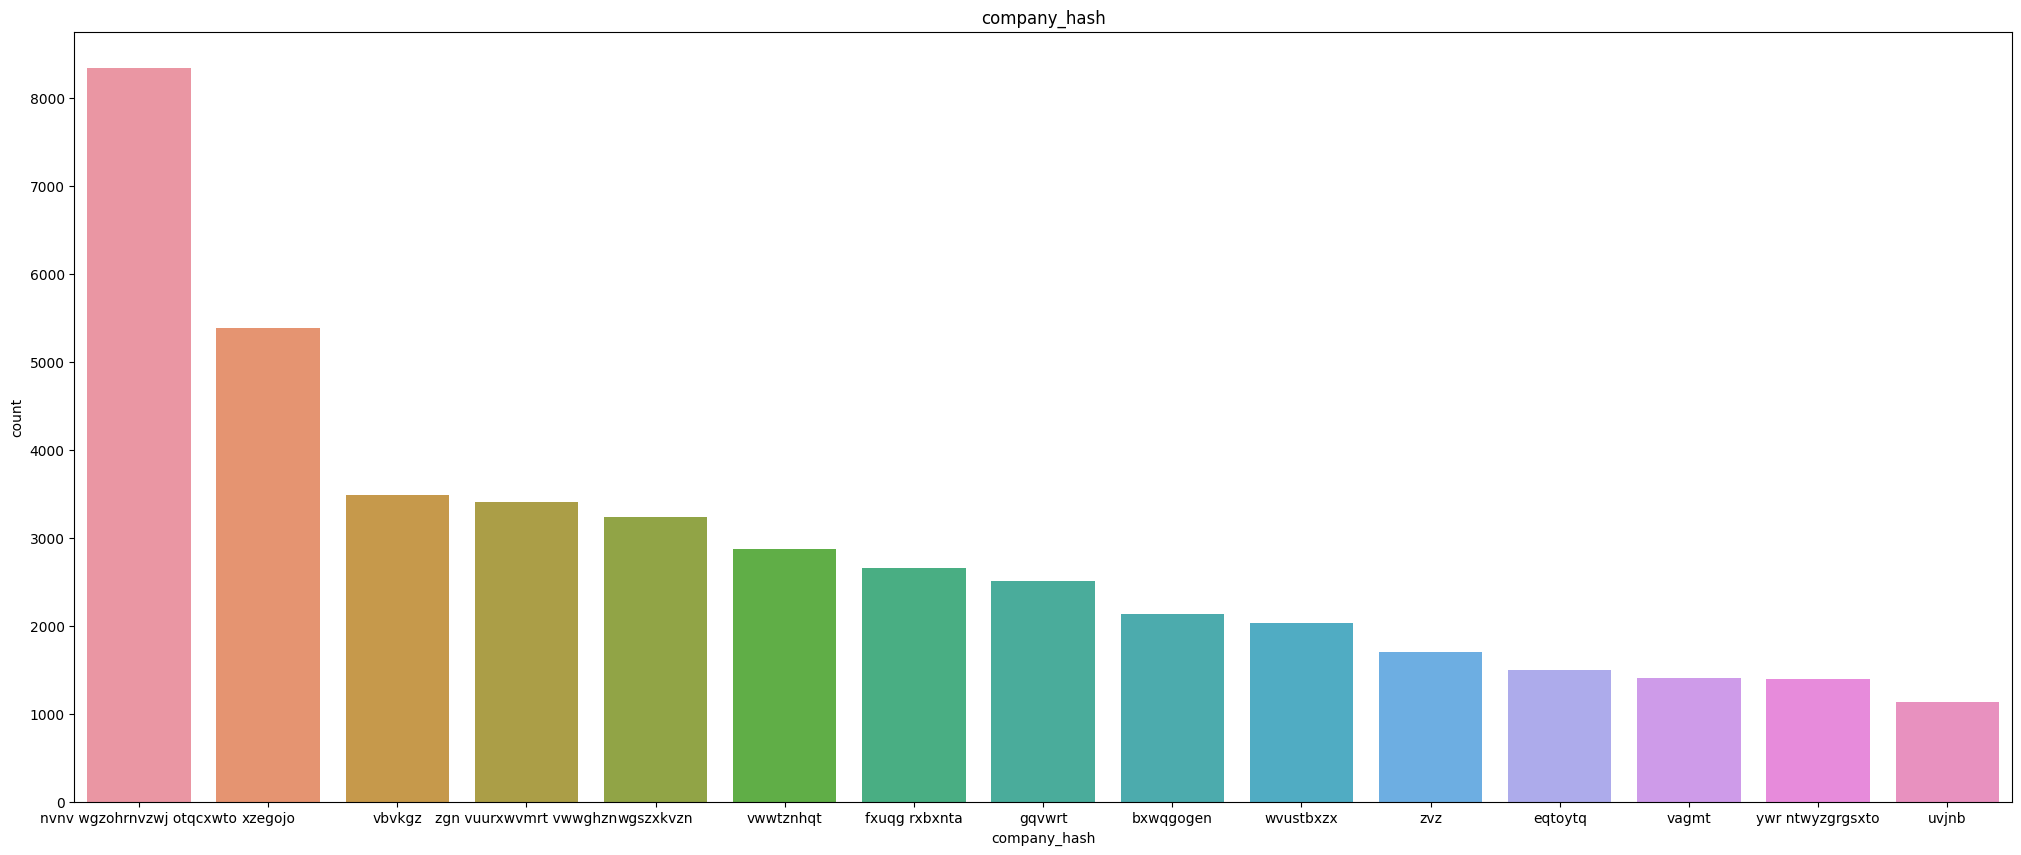

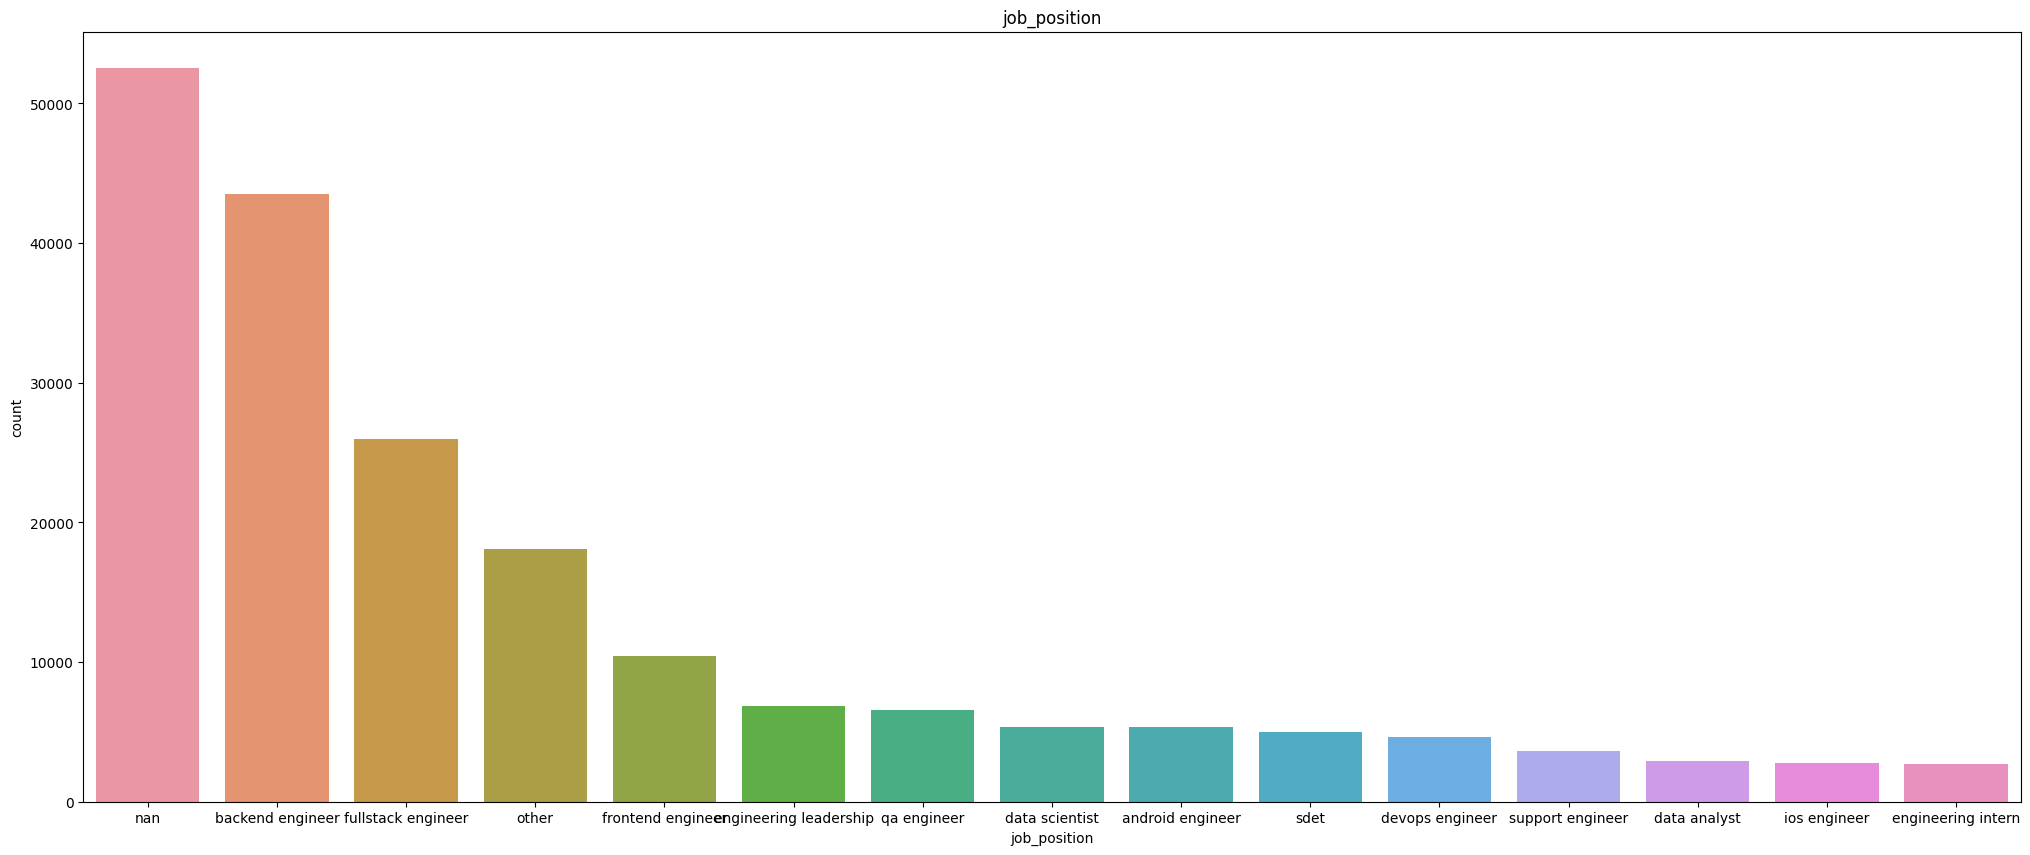

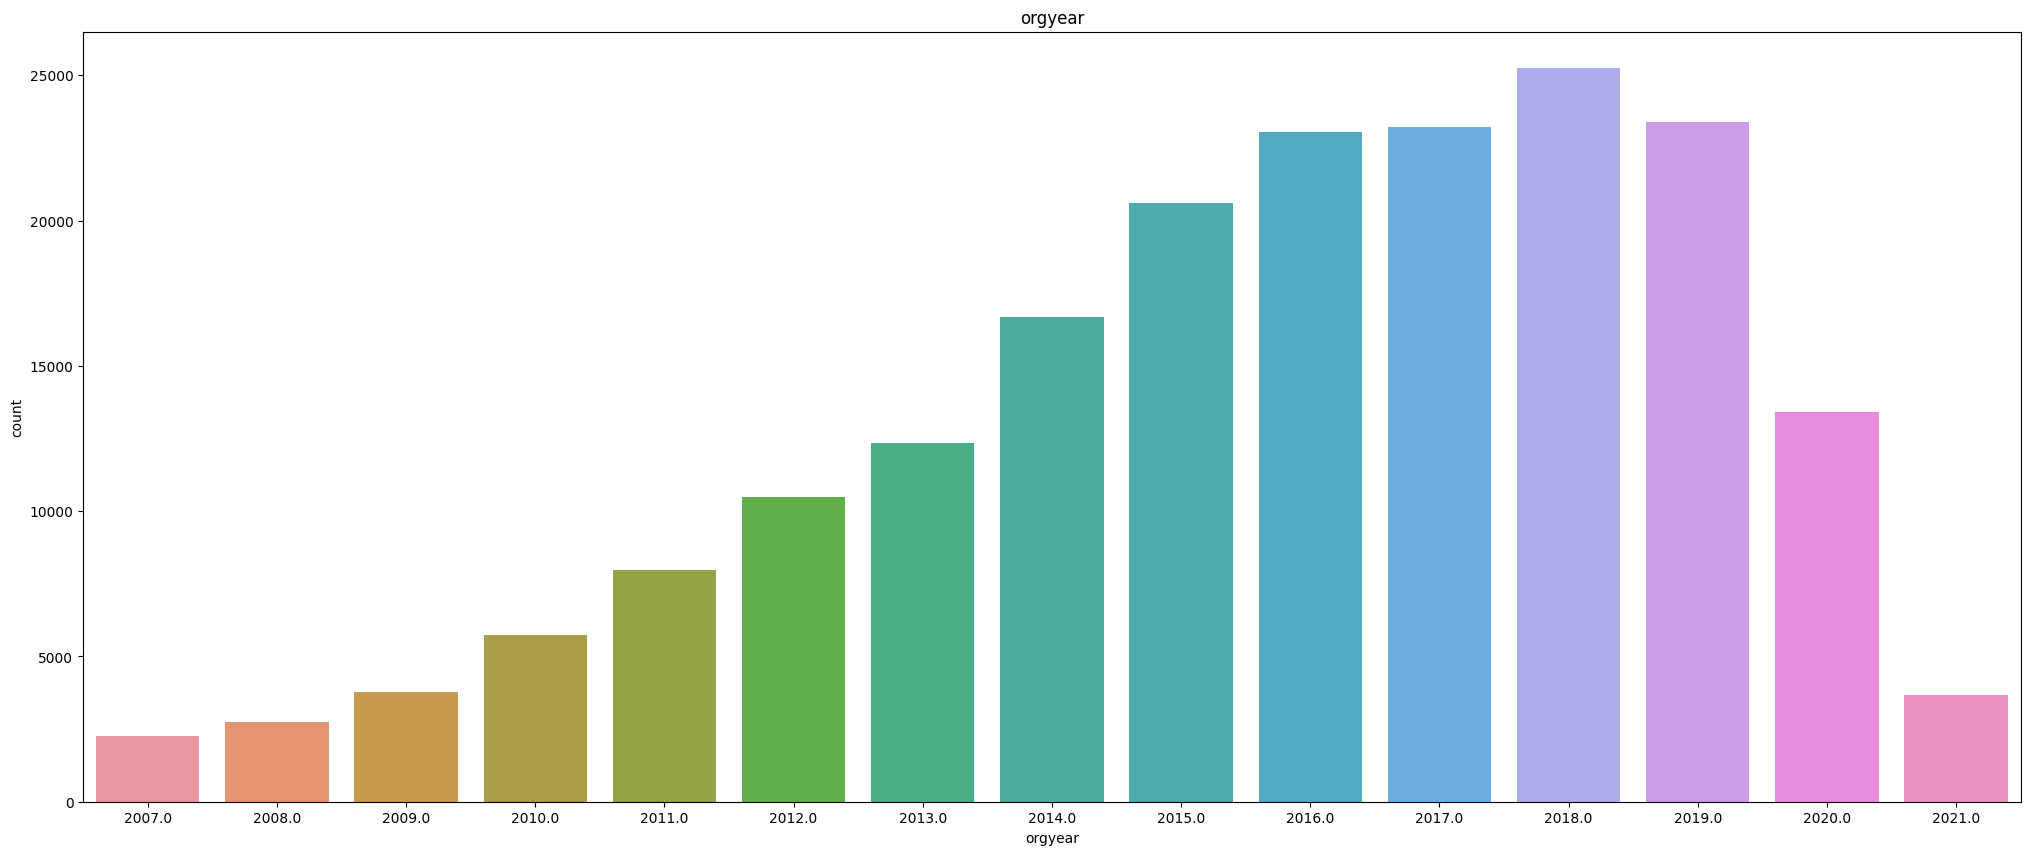

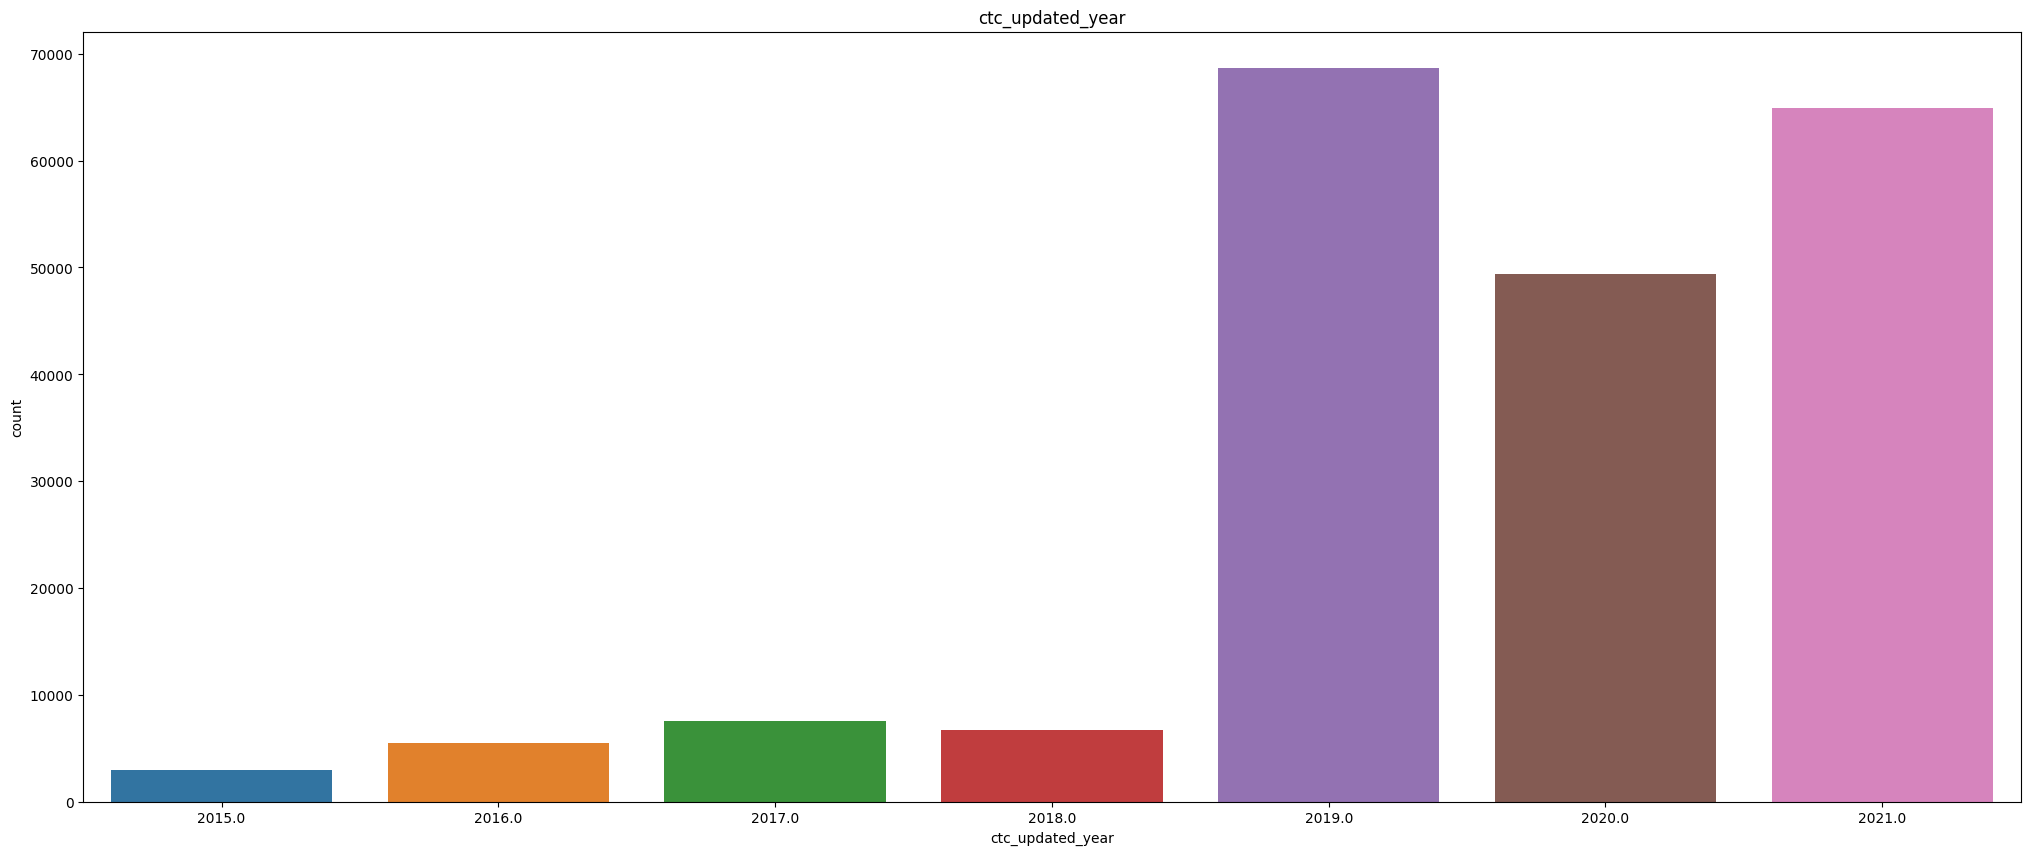

In [32]:
plot = ['company_hash','job_position','orgyear','ctc_updated_year']
for i in plot:
    tmp = df.copy()
    tmp['count'] = 1
    tmp = tmp.groupby(i).sum()['count'].reset_index().sort_values('count',ascending=False).head(15)
    plt.figure(figsize=(25,10))
    sns.barplot(data=tmp,y='count',x=i).set(title=i)
    plt.show()

## Bivariate Analysis & Multivariate Analysis

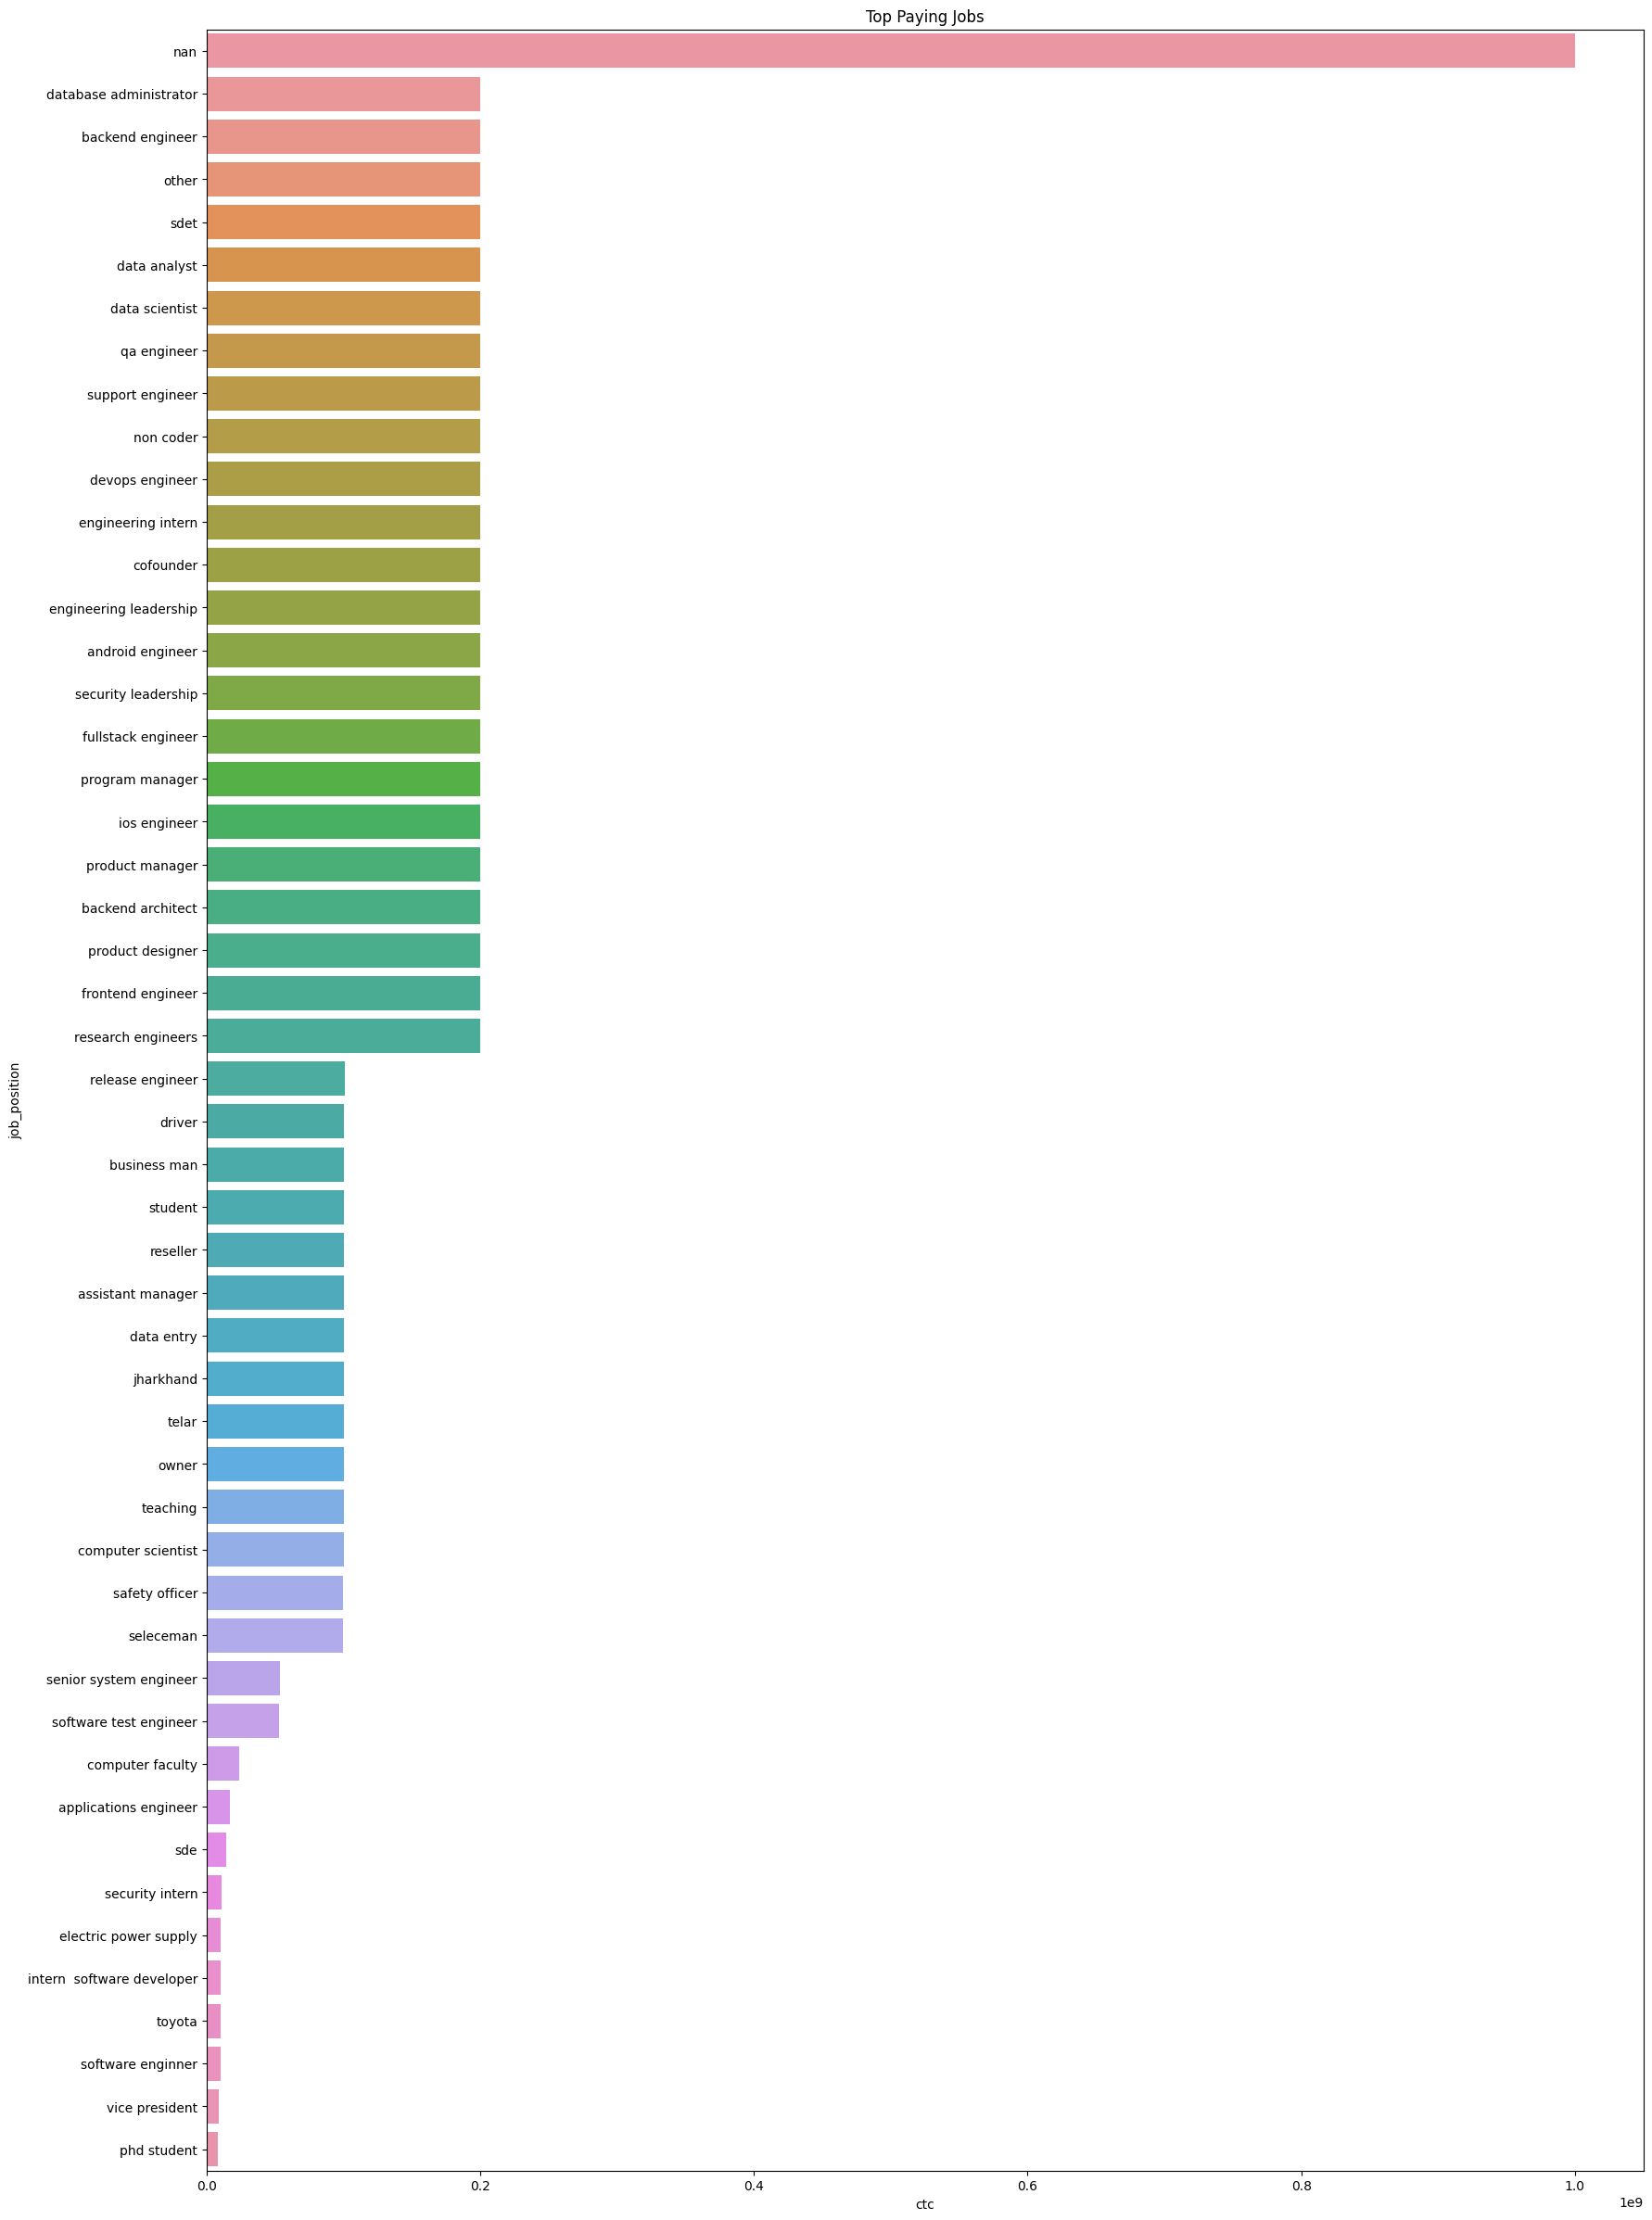

In [33]:
tmp = df.copy()
tmp = tmp.groupby(['job_position']).max()['ctc'].reset_index().sort_values('ctc',ascending=False).head(50)
plt.figure(figsize=(20,30))
sns.barplot(data=tmp,x='ctc',y='job_position').set(title="Top Paying Jobs")
plt.show()

In [34]:
list(tmp['job_position'])

['nan',
 'database administrator',
 'backend engineer',
 'other',
 'sdet',
 'data analyst',
 'data scientist',
 'qa engineer',
 'support engineer',
 'non coder',
 'devops engineer',
 'engineering intern',
 'cofounder',
 'engineering leadership',
 'android engineer',
 'security leadership',
 'fullstack engineer',
 'program manager',
 'ios engineer',
 'product manager',
 'backend architect',
 'product designer',
 'frontend engineer',
 'research engineers',
 'release engineer',
 'driver',
 'business man',
 'student',
 'reseller',
 'assistant manager',
 'data entry',
 'jharkhand',
 'telar',
 'owner',
 'teaching',
 'computer scientist',
 'safety officer',
 'seleceman',
 'senior system engineer',
 'software test engineer',
 'computer faculty',
 'applications engineer',
 'sde',
 'security intern',
 'electric power supply',
 'intern  software developer',
 'toyota',
 'software enginner',
 'vice president',
 'phd student']

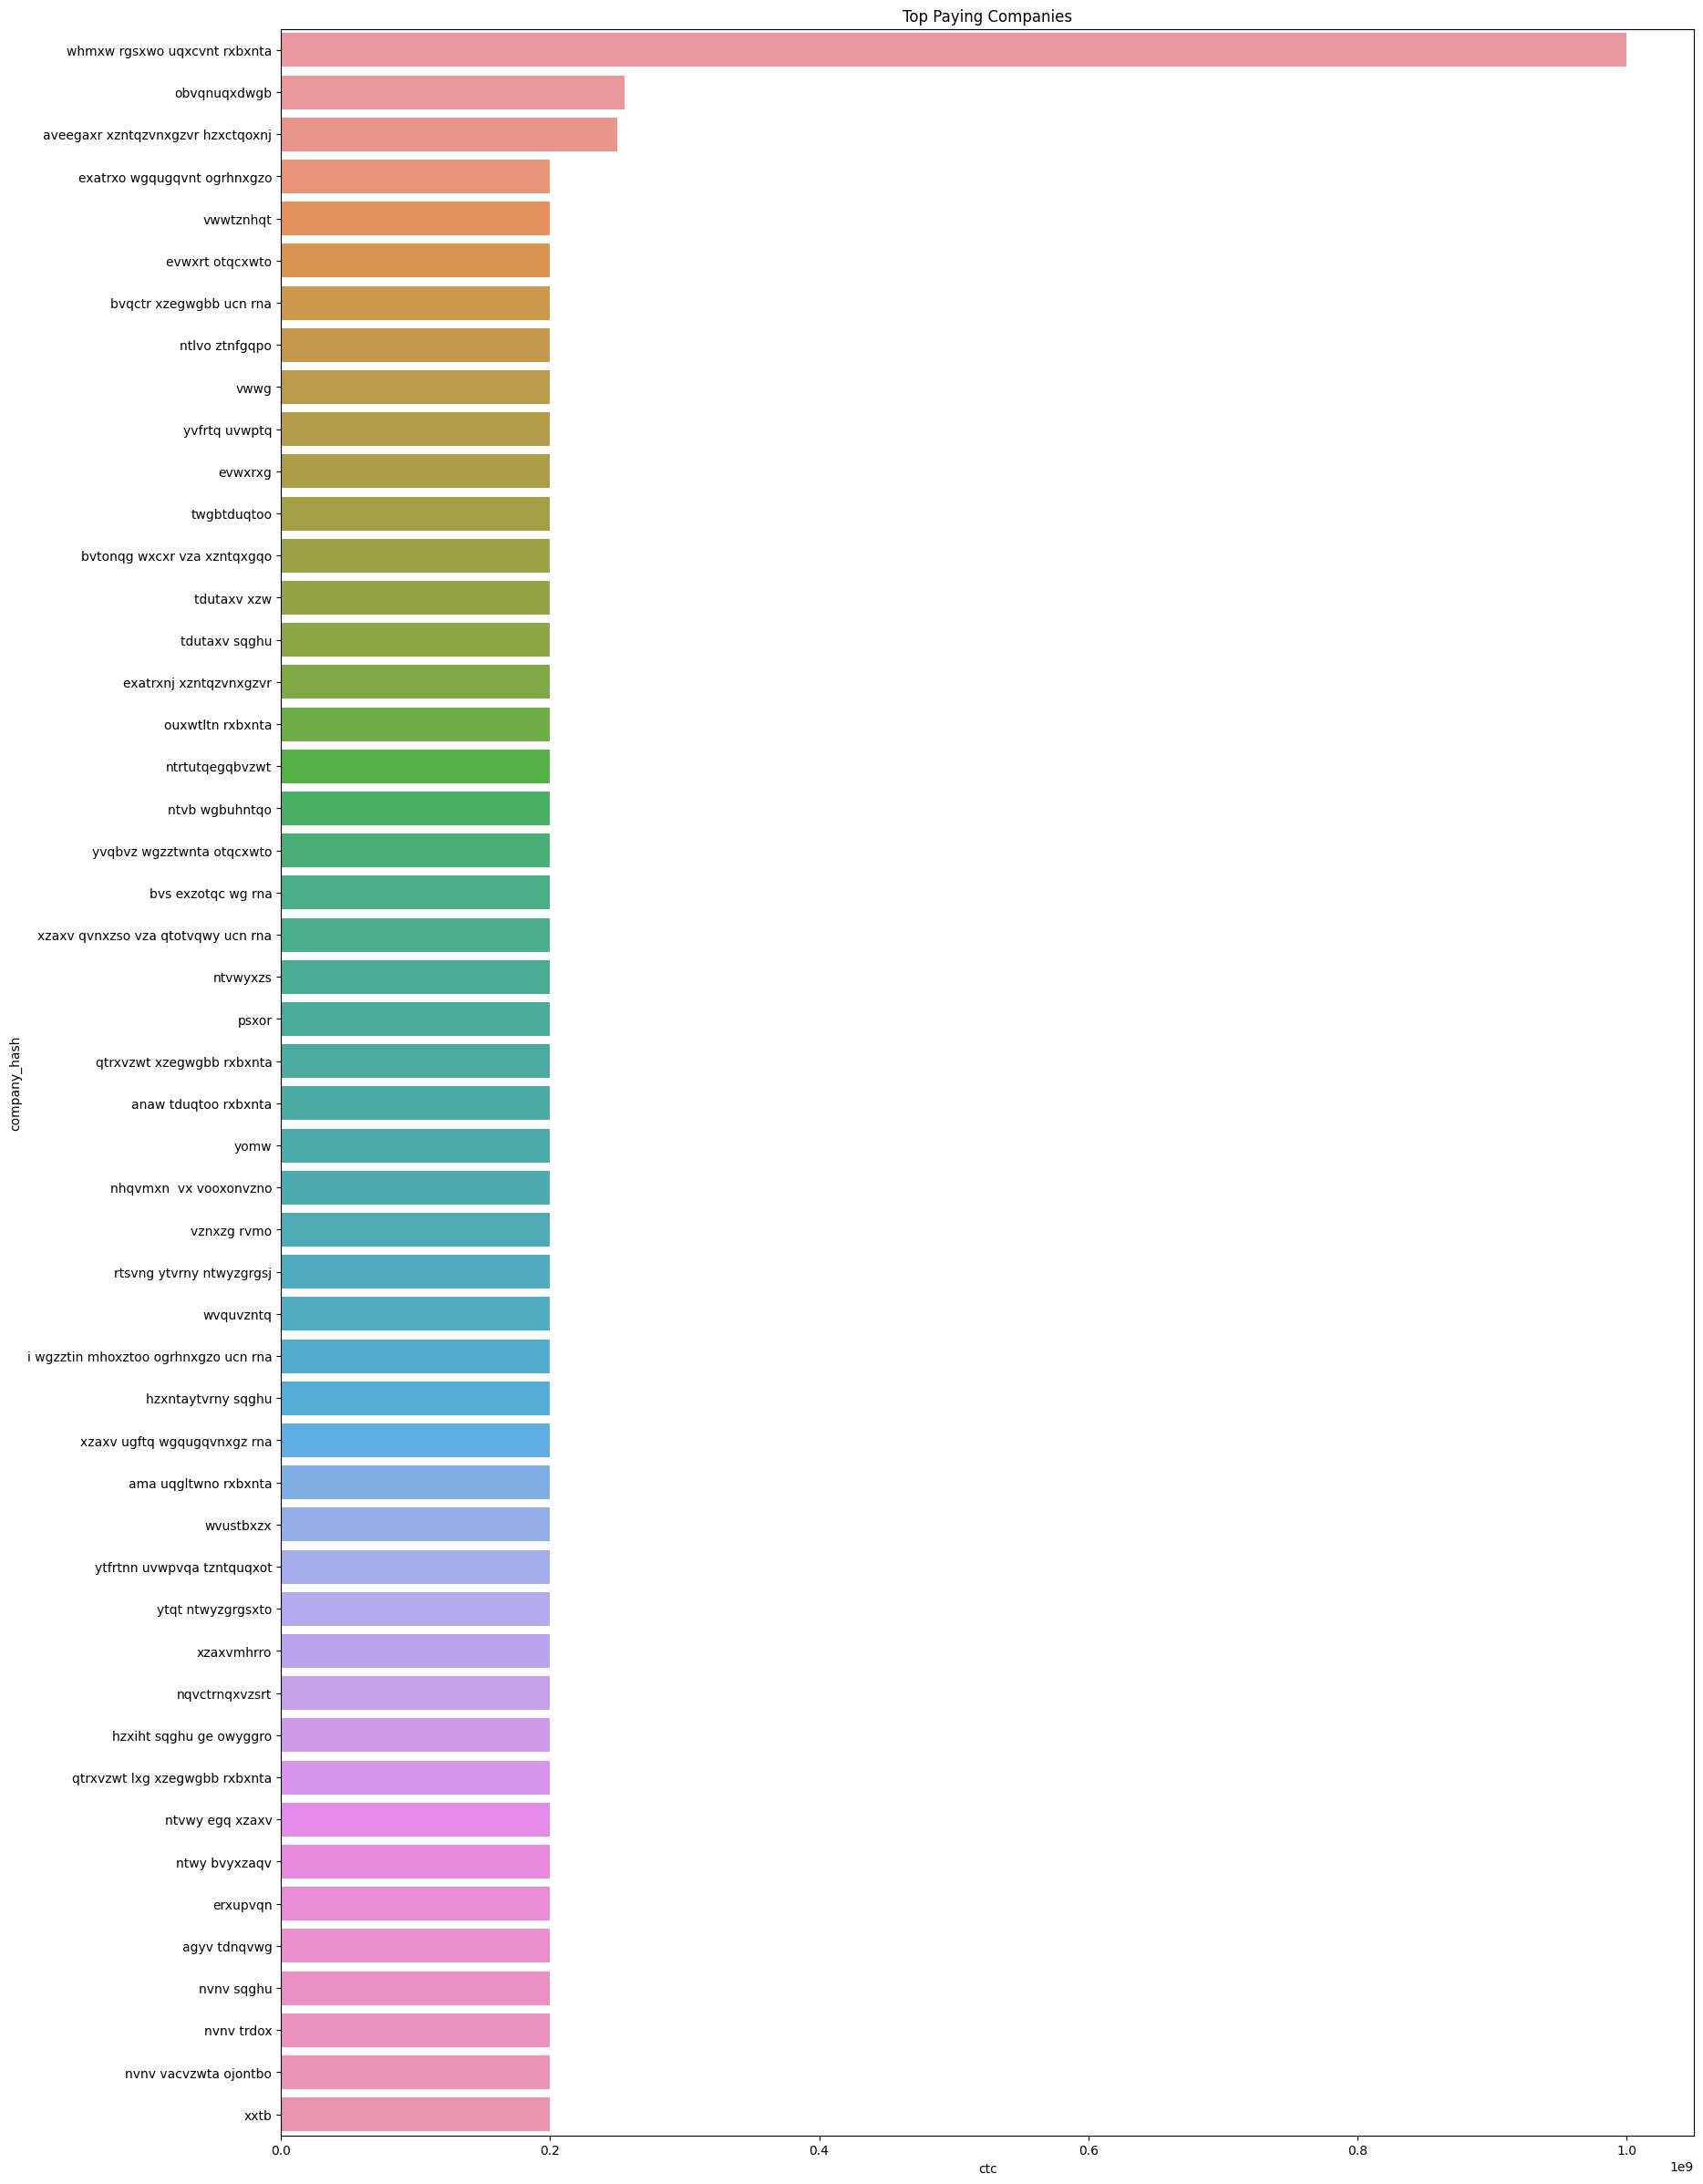

In [35]:
tmp = df.copy()
tmp = tmp.groupby(['company_hash']).max()['ctc'].reset_index().sort_values('ctc',ascending=False).head(50)
plt.figure(figsize=(20,30))
sns.barplot(data=tmp,x='ctc',y='company_hash').set(title="Top Paying Companies")
plt.show()

In [36]:
list(tmp['company_hash'])

['whmxw rgsxwo uqxcvnt rxbxnta',
 'obvqnuqxdwgb',
 'aveegaxr xzntqzvnxgzvr hzxctqoxnj',
 'exatrxo wgqugqvnt ogrhnxgzo',
 'vwwtznhqt',
 'evwxrt otqcxwto',
 'bvqctr xzegwgbb ucn rna',
 'ntlvo ztnfgqpo',
 'vwwg',
 'yvfrtq uvwptq',
 'evwxrxg',
 'twgbtduqtoo',
 'bvtonqg wxcxr vza xzntqxgqo',
 'tdutaxv xzw',
 'tdutaxv sqghu',
 'exatrxnj xzntqzvnxgzvr',
 'ouxwtltn rxbxnta',
 'ntrtutqegqbvzwt',
 'ntvb wgbuhntqo',
 'yvqbvz wgzztwnta otqcxwto',
 'bvs exzotqc wg rna',
 'xzaxv qvnxzso vza qtotvqwy ucn rna',
 'ntvwyxzs',
 'psxor',
 'qtrxvzwt xzegwgbb rxbxnta',
 'anaw tduqtoo rxbxnta',
 'yomw',
 'nhqvmxn  vx vooxonvzno',
 'vznxzg rvmo',
 'rtsvng ytvrny ntwyzgrgsj',
 'wvquvzntq',
 'i wgzztin mhoxztoo ogrhnxgzo ucn rna',
 'hzxntaytvrny sqghu',
 'xzaxv ugftq wgqugqvnxgz rna',
 'ama uqgltwno rxbxnta',
 'wvustbxzx',
 'ytfrtnn uvwpvqa tzntquqxot',
 'ytqt ntwyzgrgsxto',
 'xzaxvmhrro',
 'nqvctrnqxvzsrt',
 'hzxiht sqghu ge owyggro',
 'qtrxvzwt lxg xzegwgbb rxbxnta',
 'ntvwy egq xzaxv',
 'ntwy bvyxzaqv',
 'er

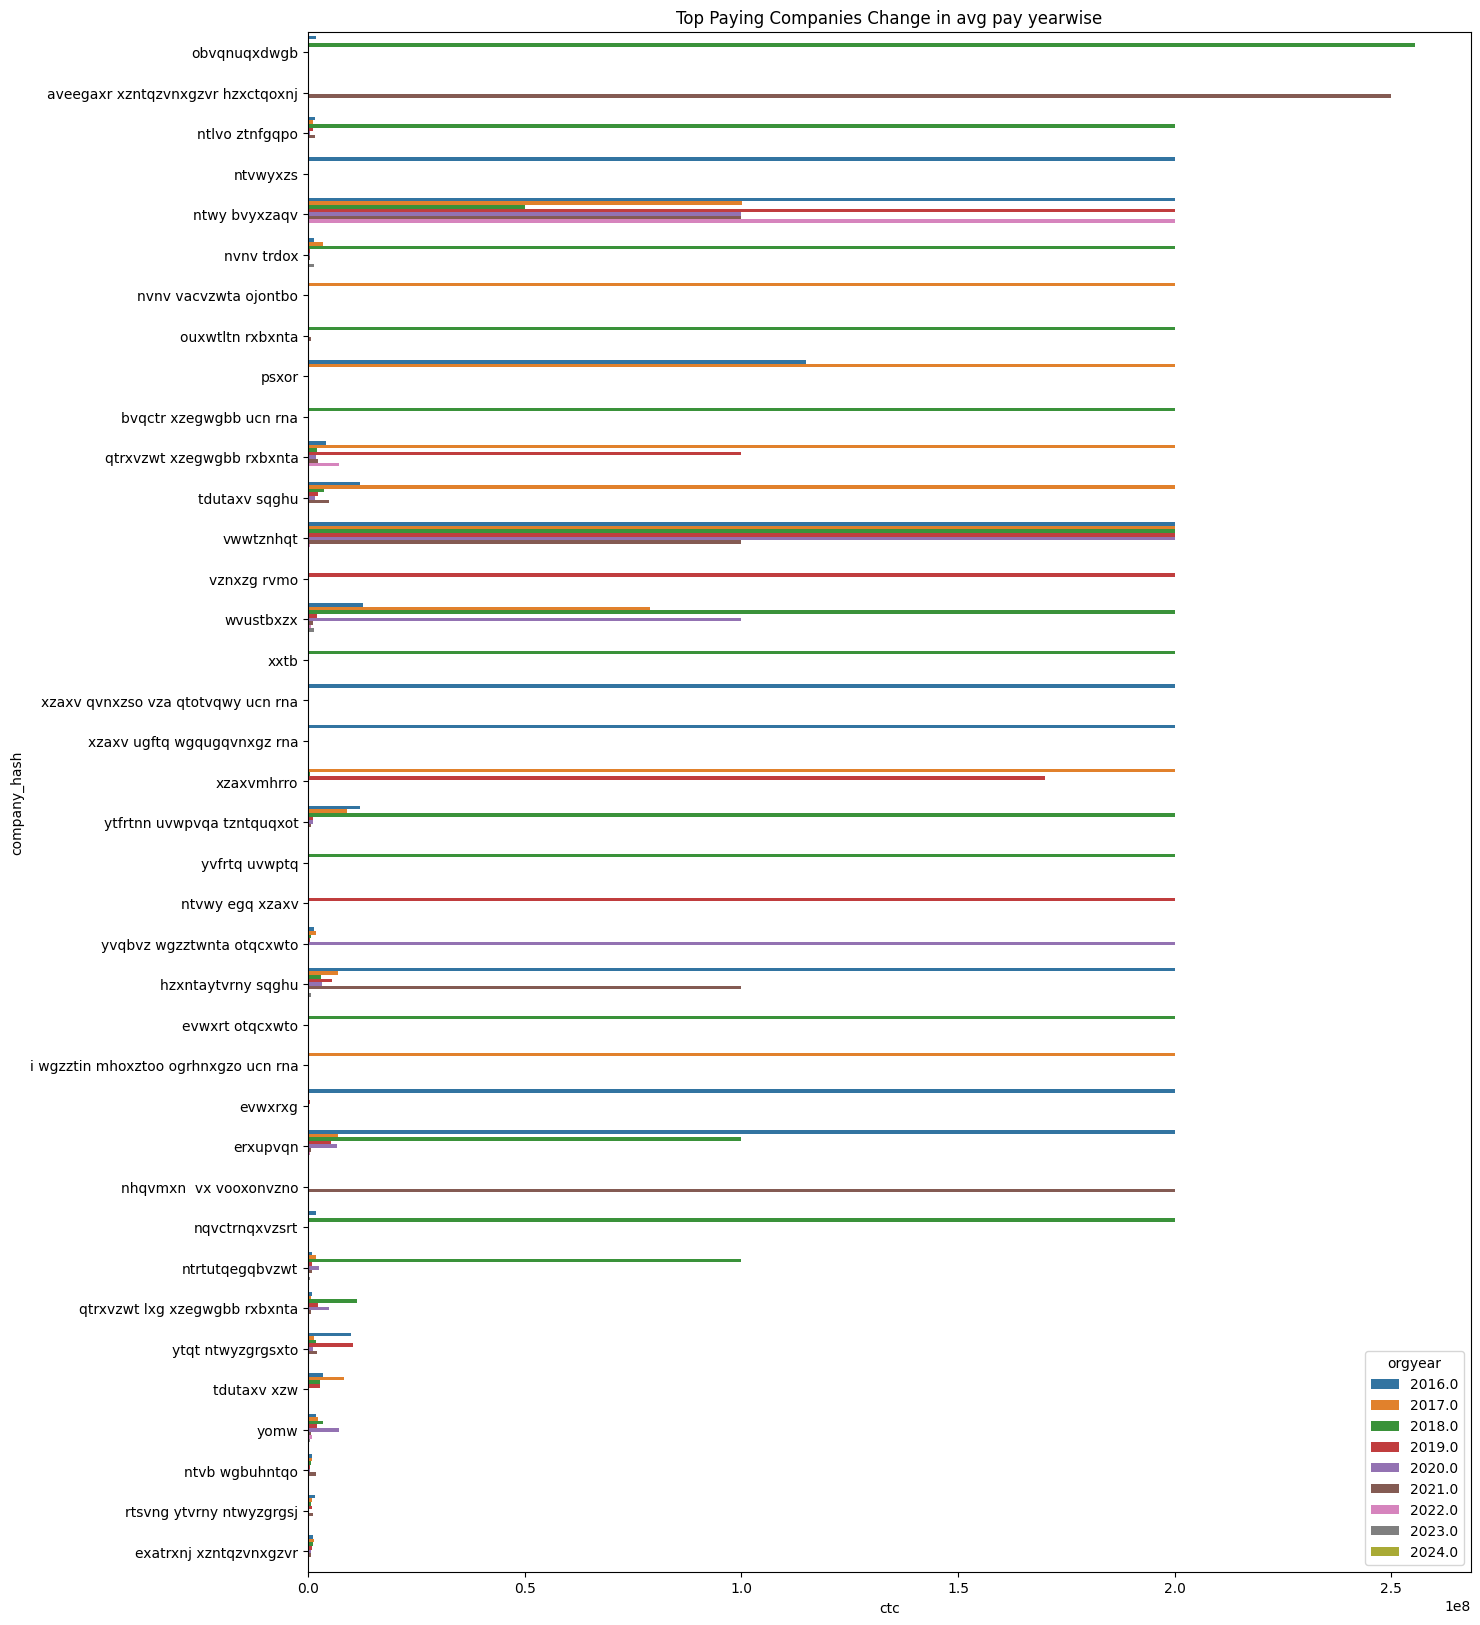

In [37]:
tmp = df.copy()
tmp = tmp[tmp['company_hash'].isin(['whmxw rgsxwo uqxcvnt rxbxnta',
 'obvqnuqxdwgb',
 'aveegaxr xzntqzvnxgzvr hzxctqoxnj',
 'exatrxo wgqugqvnt ogrhnxgzo',
 'vwwtznhqt',
 'evwxrt otqcxwto',
 'bvqctr xzegwgbb ucn rna',
 'ntlvo ztnfgqpo',
 'vwwg',
 'yvfrtq uvwptq',
 'evwxrxg',
 'twgbtduqtoo',
 'bvtonqg wxcxr vza xzntqxgqo',
 'tdutaxv xzw',
 'tdutaxv sqghu',
 'exatrxnj xzntqzvnxgzvr',
 'ouxwtltn rxbxnta',
 'ntrtutqegqbvzwt',
 'ntvb wgbuhntqo',
 'yvqbvz wgzztwnta otqcxwto',
 'bvs exzotqc wg rna',
 'xzaxv qvnxzso vza qtotvqwy ucn rna',
 'ntvwyxzs',
 'psxor',
 'qtrxvzwt xzegwgbb rxbxnta',
 'anaw tduqtoo rxbxnta',
 'yomw',
 'nhqvmxn  vx vooxonvzno',
 'vznxzg rvmo',
 'rtsvng ytvrny ntwyzgrgsj',
 'wvquvzntq',
 'i wgzztin mhoxztoo ogrhnxgzo ucn rna',
 'hzxntaytvrny sqghu',
 'xzaxv ugftq wgqugqvnxgz rna',
 'ama uqgltwno rxbxnta',
 'wvustbxzx',
 'ytfrtnn uvwpvqa tzntquqxot',
 'ytqt ntwyzgrgsxto',
 'xzaxvmhrro',
 'nqvctrnqxvzsrt',
 'hzxiht sqghu ge owyggro',
 'qtrxvzwt lxg xzegwgbb rxbxnta',
 'ntvwy egq xzaxv',
 'ntwy bvyxzaqv',
 'erxupvqn',
 'agyv tdnqvwg',
 'nvnv sqghu',
 'nvnv trdox',
 'nvnv vacvzwta ojontbo',
 'xxtb'])]
tmp = tmp[tmp['orgyear'] >= 2016]
tmp = tmp.groupby(['company_hash','orgyear']).max()['ctc'].reset_index().sort_values('ctc',ascending=False)
plt.figure(figsize=(15,20))
sns.barplot(data=tmp,x='ctc',y='company_hash',hue='orgyear').set(title="Top Paying Companies Change in avg pay yearwise")
plt.show()

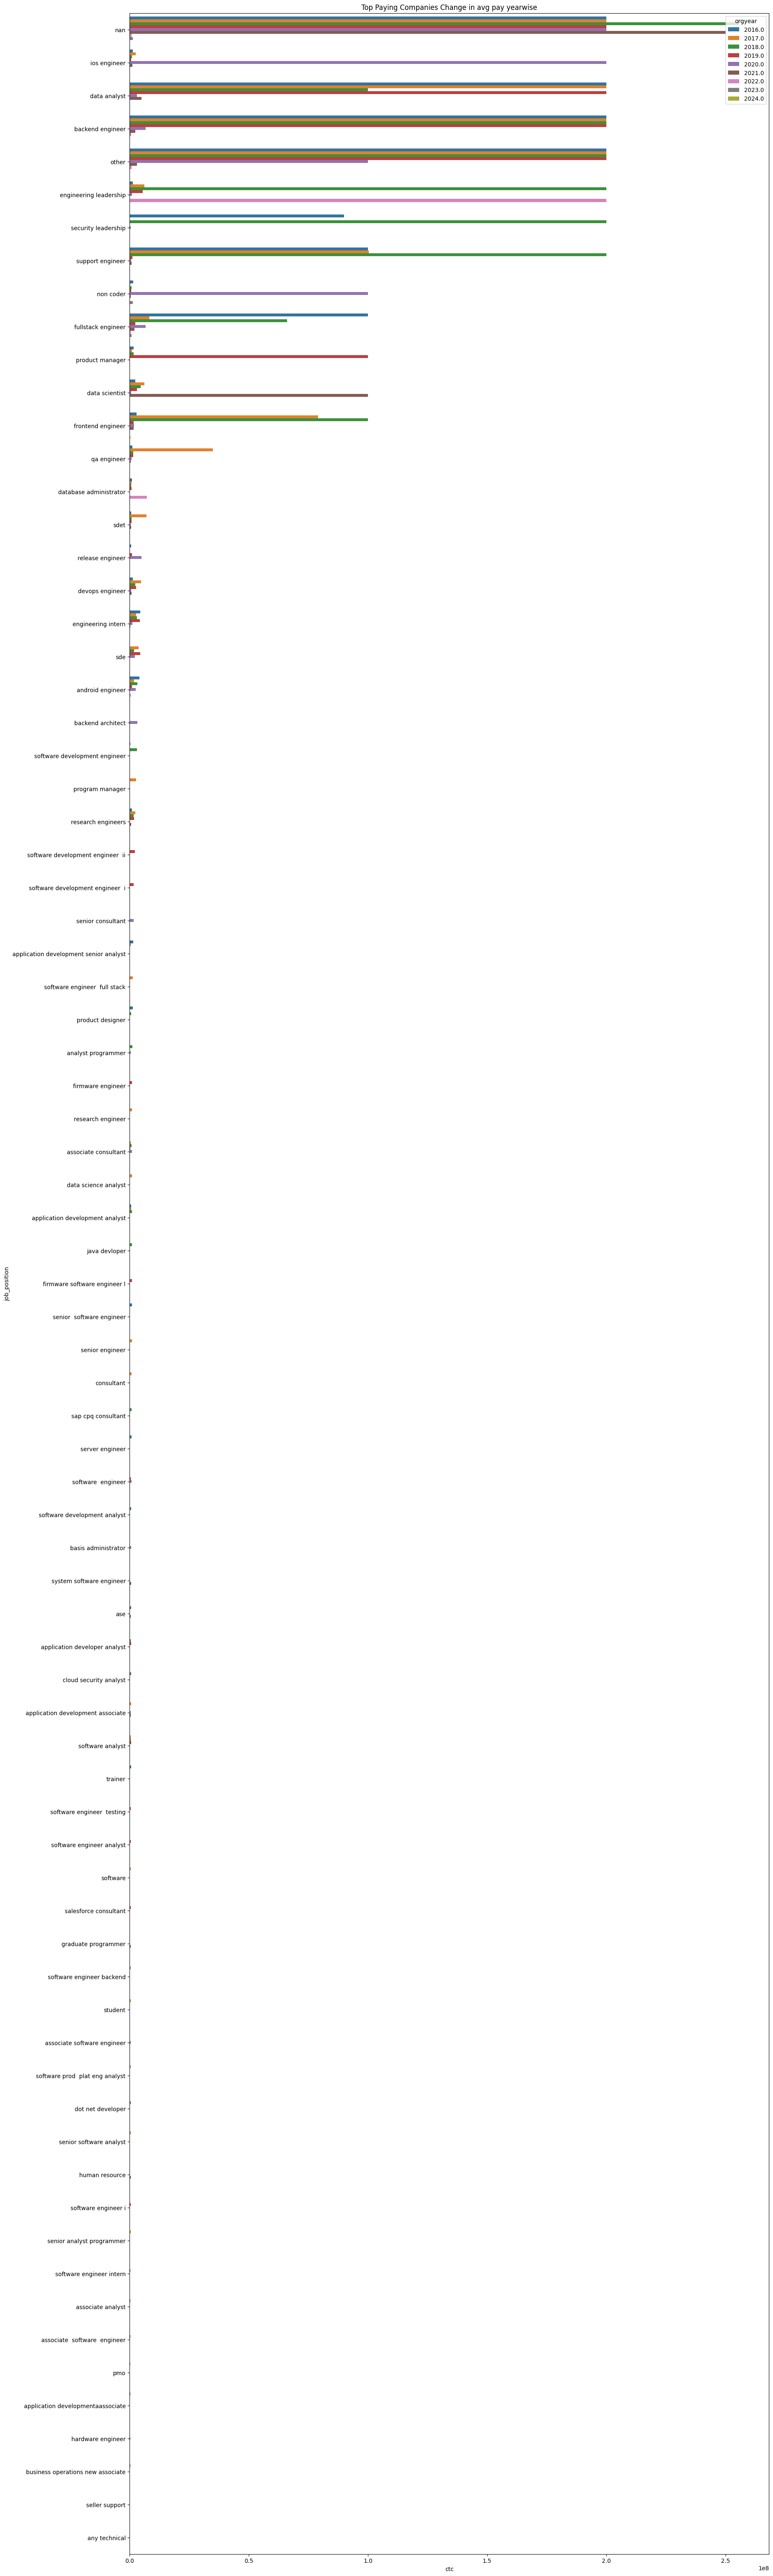

In [38]:
tmp = df.copy()
tmp = tmp[tmp['company_hash'].isin(['whmxw rgsxwo uqxcvnt rxbxnta',
 'obvqnuqxdwgb',
 'aveegaxr xzntqzvnxgzvr hzxctqoxnj',
 'exatrxo wgqugqvnt ogrhnxgzo',
 'vwwtznhqt',
 'evwxrt otqcxwto',
 'bvqctr xzegwgbb ucn rna',
 'ntlvo ztnfgqpo',
 'vwwg',
 'yvfrtq uvwptq',
 'evwxrxg',
 'twgbtduqtoo',
 'bvtonqg wxcxr vza xzntqxgqo',
 'tdutaxv xzw',
 'tdutaxv sqghu',
 'exatrxnj xzntqzvnxgzvr',
 'ouxwtltn rxbxnta',
 'ntrtutqegqbvzwt',
 'ntvb wgbuhntqo',
 'yvqbvz wgzztwnta otqcxwto',
 'bvs exzotqc wg rna',
 'xzaxv qvnxzso vza qtotvqwy ucn rna',
 'ntvwyxzs',
 'psxor',
 'qtrxvzwt xzegwgbb rxbxnta',
 'anaw tduqtoo rxbxnta',
 'yomw',
 'nhqvmxn  vx vooxonvzno',
 'vznxzg rvmo',
 'rtsvng ytvrny ntwyzgrgsj',
 'wvquvzntq',
 'i wgzztin mhoxztoo ogrhnxgzo ucn rna',
 'hzxntaytvrny sqghu',
 'xzaxv ugftq wgqugqvnxgz rna',
 'ama uqgltwno rxbxnta',
 'wvustbxzx',
 'ytfrtnn uvwpvqa tzntquqxot',
 'ytqt ntwyzgrgsxto',
 'xzaxvmhrro',
 'nqvctrnqxvzsrt',
 'hzxiht sqghu ge owyggro',
 'qtrxvzwt lxg xzegwgbb rxbxnta',
 'ntvwy egq xzaxv',
 'ntwy bvyxzaqv',
 'erxupvqn',
 'agyv tdnqvwg',
 'nvnv sqghu',
 'nvnv trdox',
 'nvnv vacvzwta ojontbo',
 'xxtb'])]
tmp = tmp[tmp['orgyear'] >= 2016]
tmp = tmp.groupby(['job_position','orgyear']).max()['ctc'].reset_index().sort_values('ctc',ascending=False)
plt.figure(figsize=(20,80))
sns.barplot(data=tmp,x='ctc',y='job_position',hue='orgyear').set(title="Top Paying Companies Change in avg pay yearwise")
plt.show()

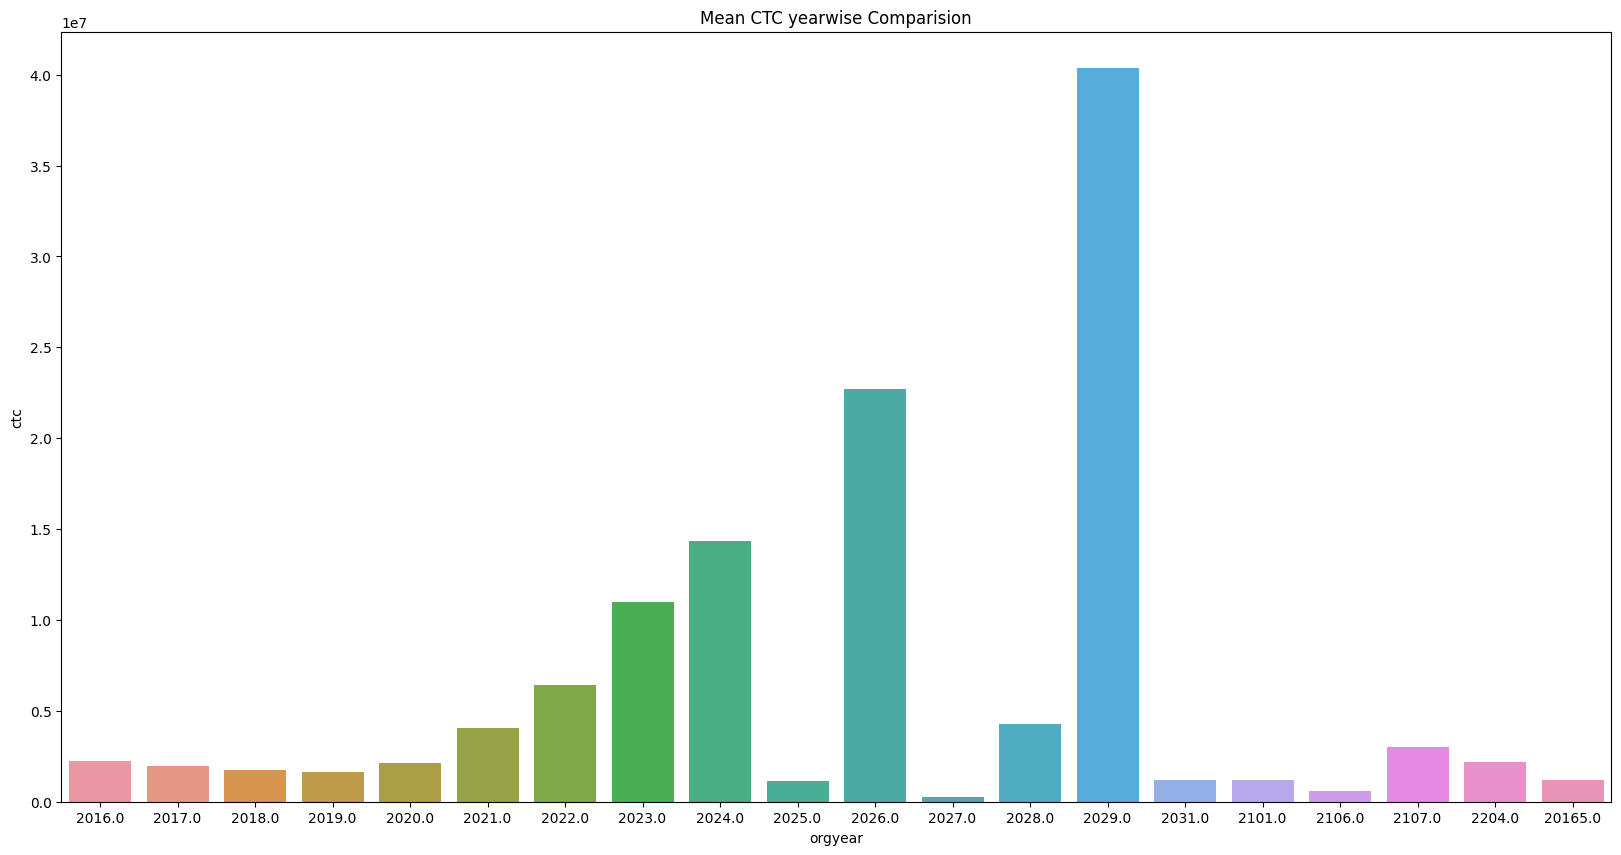

In [39]:
tmp = df.copy()
tmp = tmp[tmp['orgyear'] >= 2016]
tmp = tmp.groupby(['orgyear']).mean()['ctc'].reset_index().sort_values('ctc',ascending=False).head(50)
plt.figure(figsize=(20,10))
sns.barplot(data=tmp,y='ctc',x='orgyear').set(title="Mean CTC yearwise Comparision")
plt.show()

## Outlier Treatment
### Orgyear

In [40]:
df["orgyear"].value_counts()

2018.0    25240
2019.0    23402
2017.0    23237
2016.0    23038
2015.0    20602
          ...  
2107.0        1
1972.0        1
2101.0        1
208.0         1
200.0         1
Name: orgyear, Length: 78, dtype: int64

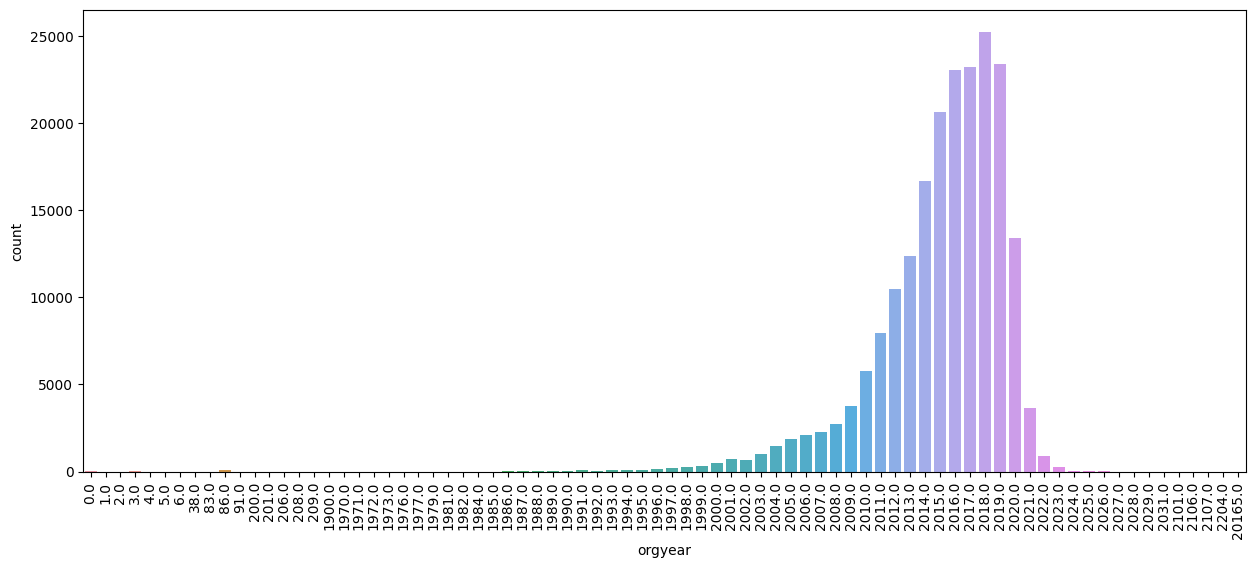

In [41]:
plt.figure(figsize=(15,6))
sns.countplot(x=df['orgyear'])
plt.xticks(rotation = 90)
plt.show()

In [42]:
df["orgyear"].quantile(0.001)

1990.0

In [43]:
df["orgyear"].quantile(0.999)

2023.0

In [44]:
df["orgyear"] = df["orgyear"].clip(1990,2022)

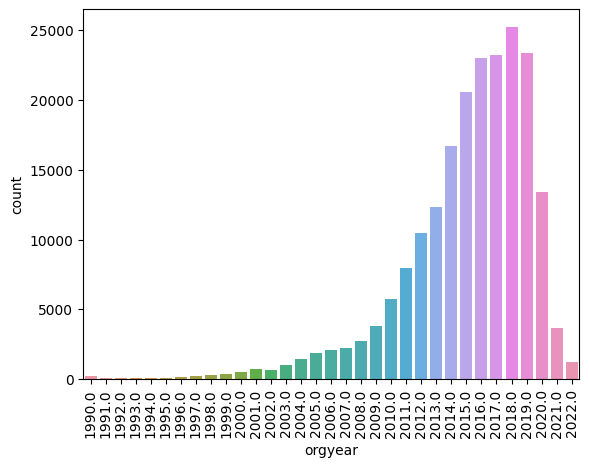

In [45]:
sns.countplot(x=df['orgyear'])
plt.xticks(rotation = 90)
plt.show()

### CTC

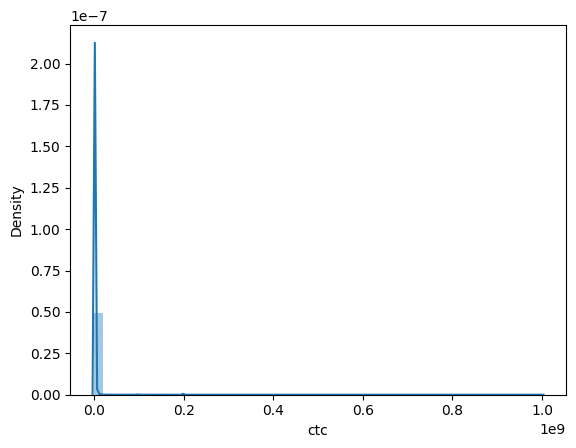

In [46]:
sns.distplot(df["ctc"])
plt.show()

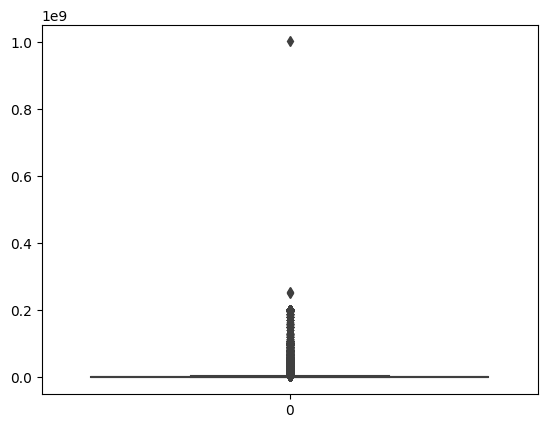

In [47]:
sns.boxplot(df["ctc"])
plt.show()

In [48]:
df["ctc"].quantile(0.01)

37000.0

In [49]:
df["ctc"].quantile(0.999)

200000000.0

In [50]:
df = df.loc[((df.ctc) > df.ctc.quantile(0.01)) & ((df.ctc) < df.ctc.quantile(0.99))]

In [51]:
df.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,other,2020.0
1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999,fullstack engineer,2019.0
2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000,backend engineer,2020.0
3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000,backend engineer,2019.0
4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000,fullstack engineer,2019.0


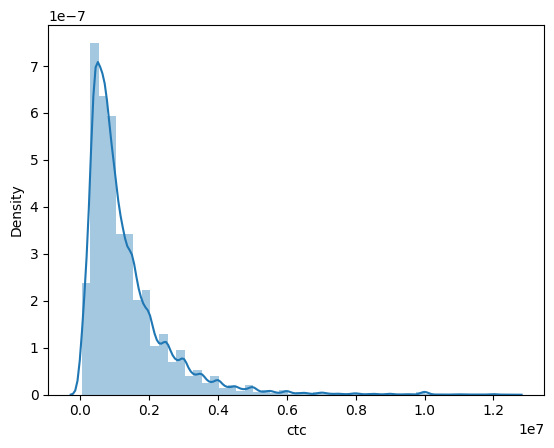

In [52]:
sns.distplot(df["ctc"])
plt.show()

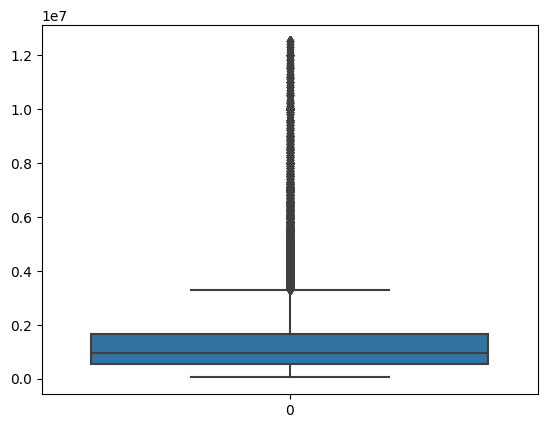

In [53]:
sns.boxplot(df["ctc"])
plt.show()

### ctc updated_year

In [54]:
df["ctc_updated_year"].quantile(0.001)

2015.0

In [55]:
df["ctc_updated_year"].quantile(0.99)

2021.0

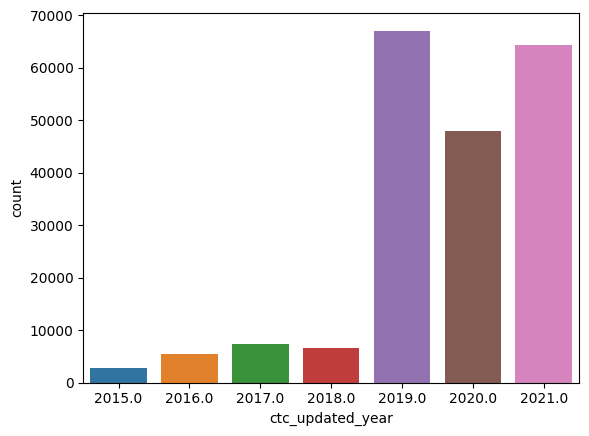

In [56]:
sns.countplot(x=df['ctc_updated_year'])
plt.show()

In [57]:
df.loc[df['job_position']=='nan', 'job_position']=np.nan

In [58]:
df.loc[df["company_hash"]=="nan","company_hash"] = np.nan

## Feature Engineering
#### Masked company name to "Others" having count less than 5

In [59]:
df.loc[df.groupby("company_hash")["ctc"].transform("count") < 5,"company_hash"] = "Others"

In [60]:
(df["company_hash"] == "Others").sum()

46434

In [61]:
df['orgyear'].describe()

count    201625.000000
mean       2015.104769
std           4.256063
min        1990.000000
25%        2013.000000
50%        2016.000000
75%        2018.000000
max        2022.000000
Name: orgyear, dtype: float64

In [62]:
# years of experience = current year - employement start year
df["years_of_experience"] = 2024 - df["orgyear"] 

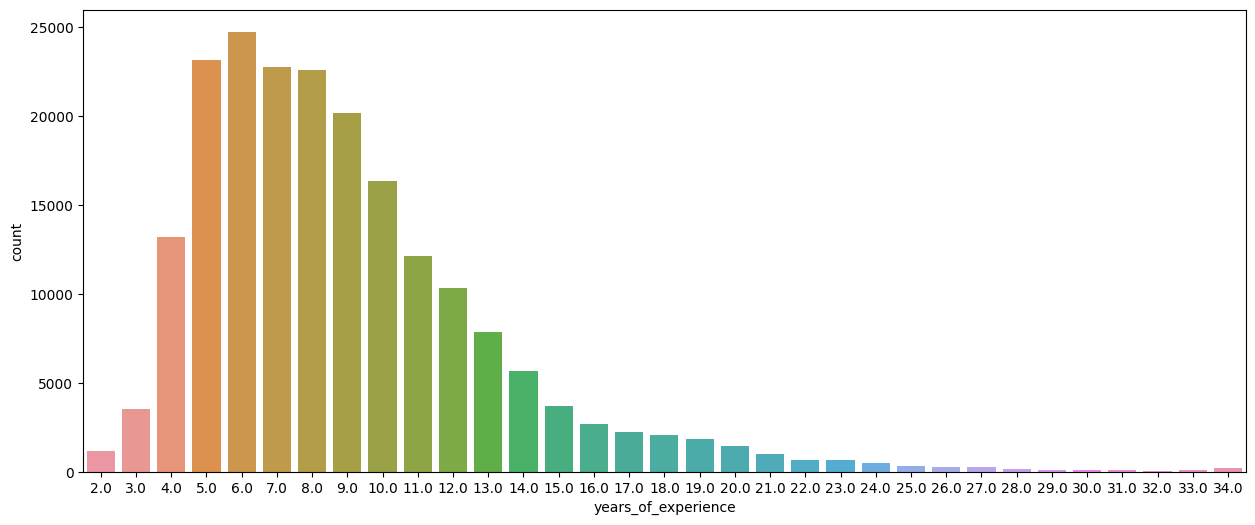

In [63]:
plt.figure(figsize=(15,6))
sns.countplot(x=df['years_of_experience'])
plt.show()

In [64]:
df.duplicated().sum()

212

In [65]:
df.drop_duplicates(inplace=True)

In [66]:
df.isna().sum()

company_hash              42
email_hash                 0
orgyear                    0
ctc                        0
job_position           51671
ctc_updated_year           0
years_of_experience        0
dtype: int64

In [67]:
# records having ctc_updated_year higher than their organization joining year
(df["ctc_updated_year"] < df["orgyear"]).sum()

8465

In [68]:
df.ctc_updated_year = df[["ctc_updated_year","orgyear"]].max(axis = 1)

In [69]:
(df["ctc_updated_year"] < df["orgyear"]).sum()

0

In [70]:
df.sample(2)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience
11711,Others,feed3529e8360ae24b721dec3eac9124b104886d36b722...,2018.0,500000,other,2020.0,6.0
109030,ovbohzs qa xzonxnhnt xzaxv atryx,fc1ffb7be86e45f41c95b140b066e2a639ac54d10cf096...,2018.0,1950000,backend engineer,2021.0,6.0


In [71]:
# Filling null values with others -- if not done before
df['job_position'] = df['job_position'].fillna('Others')
df['company_hash'] = df['company_hash'].fillna('Others')

In [72]:
df.isna().sum()

company_hash           0
email_hash             0
orgyear                0
ctc                    0
job_position           0
ctc_updated_year       0
years_of_experience    0
dtype: int64

In [73]:
df.duplicated().sum()

103

In [74]:
df.describe()

,orgyear,ctc,ctc_updated_year,years_of_experience
count,201413.000000,2.014130e+05,201413.000000,201413.000000
mean,2015.103722,1.313212e+06,2019.687314,8.896278
std,4.257499,1.234111e+06,1.287119,4.257499
min,1990.000000,3.800000e+04,2015.000000,2.000000
25%,2013.000000,5.500000e+05,2019.000000,6.000000
50%,2016.000000,9.500000e+05,2020.000000,8.000000
75%,2018.000000,1.650000e+06,2021.000000,11.000000
max,2022.000000,1.250000e+07,2022.000000,34.000000


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201413 entries, 0 to 205842
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   company_hash         201413 non-null  object 
 1   email_hash           201413 non-null  object 
 2   orgyear              201413 non-null  float64
 3   ctc                  201413 non-null  int64  
 4   job_position         201413 non-null  object 
 5   ctc_updated_year     201413 non-null  float64
 6   years_of_experience  201413 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 12.3+ MB


## Manual Clustering

In [76]:
grp = ['company_hash','job_position','years_of_experience']
data_tmp1 = df.groupby(grp).agg({'ctc':['mean','median','min','max','count']}).reset_index()
data_tmp1.columns  = ["{} {}".format(b_, a_) if a_ not in grp else "{}".format(a_) for a_, b_ in zip(data_tmp1.columns.droplevel(1), data_tmp1.columns.droplevel(0))  ]
data_tmp1.head()

,company_hash,job_position,years_of_experience,mean ctc,median ctc,min ctc,max ctc,count ctc
0,Others,Others,2.0,1.492754e+06,800000.0,60000,10000000,69
1,Others,Others,3.0,9.209444e+05,650000.0,47000,10000000,187
2,Others,Others,4.0,8.635434e+05,550000.0,40000,10000000,792
3,Others,Others,5.0,7.519201e+05,500000.0,40000,10460000,1393
4,Others,Others,6.0,6.756606e+05,500000.0,40000,10000000,1108


In [77]:
datatmp = df.merge(data_tmp1[['company_hash', 'job_position', 'years_of_experience', 'mean ctc']],on=['company_hash', 'job_position', 'years_of_experience'],how='left')
col1 = 'ctc'
col2 = 'mean ctc' 
conditions  = [ datatmp[col1] > datatmp[col2], datatmp[col1] == datatmp[col2], datatmp[col1] < datatmp[col2] ]
choices     = [ 1, 2, 3 ]
    
datatmp['Designation'] = np.select(conditions, choices, default=np.nan)
datatmp.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,mean ctc,Designation
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,other,2020.0,8.0,1.100000e+06,2.0
1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999,fullstack engineer,2019.0,6.0,7.742856e+05,3.0
2,Others,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000,backend engineer,2020.0,9.0,1.188813e+06,1.0
3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000,backend engineer,2019.0,7.0,1.158571e+06,3.0
4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000,fullstack engineer,2019.0,7.0,1.400000e+06,2.0


In [78]:
# unique value designation column(listed in %)
designation = datatmp['Designation'].value_counts(normalize=True).map(lambda calc: round(100*calc,2)).reset_index()
designation.columns = ['Designation', 'Count']
designation

,Designation,Count
0,3.0,46.16
1,1.0,30.33
2,2.0,23.52


### Manual Clustering on company_hash and job position

In [79]:
grp = ['company_hash','job_position']
data_tmp1 = datatmp.groupby(grp).agg({'ctc':[('mean2','mean'),'median','min','max','count']}).reset_index()
data_tmp1.columns  = ["{} {}".format(b_, a_) if a_ not in grp else "{}".format(a_) for a_, b_ in zip(data_tmp1.columns.droplevel(1), data_tmp1.columns.droplevel(0))  ]
data_tmp1.head()

,company_hash,job_position,mean2 ctc,median ctc,min ctc,max ctc,count ctc
0,Others,Others,9.977383e+05,700000.0,40000,12500000,9450
1,Others,a group chat application,5.000000e+05,500000.0,500000,500000,1
2,Others,abap developer,5.000000e+05,500000.0,500000,500000,1
3,Others,administrative clerk,5.000000e+05,500000.0,500000,500000,1
4,Others,administrator,1.940000e+06,1940000.0,380000,3500000,2


In [80]:
datatmp = datatmp.merge(data_tmp1[grp + ['mean2 ctc']],on=grp,how='left')
col1 = 'ctc'
col2 = 'mean2 ctc' 
conditions  = [ datatmp[col1] > datatmp[col2], datatmp[col1] == datatmp[col2], datatmp[col1] < datatmp[col2] ]
choices     = [ 1, 2, 3 ]
    
datatmp['Class'] = np.select(conditions, choices, default=np.nan)
datatmp.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,mean ctc,Designation,mean2 ctc,Class
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,other,2020.0,8.0,1.100000e+06,2.0,1.085000e+06,1.0
1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999,fullstack engineer,2019.0,6.0,7.742856e+05,3.0,9.882000e+05,3.0
2,Others,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000,backend engineer,2020.0,9.0,1.188813e+06,1.0,1.204872e+06,1.0
3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000,backend engineer,2019.0,7.0,1.158571e+06,3.0,1.500000e+06,3.0
4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000,fullstack engineer,2019.0,7.0,1.400000e+06,2.0,8.466667e+05,1.0


In [81]:
# unique value Class column(listed in %)
Class = datatmp['Class'].value_counts(normalize=True).map(lambda calc: round(100*calc,2)).reset_index()
Class.columns = ['Class', 'Count']
Class

,Class,Count
0,3.0,57.98
1,1.0,35.78
2,2.0,6.24


## Manual Clustering based on comapny
#### based on ctc per company , assigning company as tier 1 2 and 3 per each learners

In [82]:
grp = ['company_hash']
data_tmp1 = datatmp.groupby(grp).agg({'ctc':[('mean3','mean'),'median','min','max','count']}).reset_index()
data_tmp1.columns  = ["{} {}".format(b_, a_) if a_ not in grp else "{}".format(a_) for a_, b_ in zip(data_tmp1.columns.droplevel(1), data_tmp1.columns.droplevel(0))  ]
data_tmp1.head()

,company_hash,mean3 ctc,median ctc,min ctc,max ctc,count ctc
0,Others,1.108693e+06,770000.0,38000,12500000,46376
1,a ntwyzgrgsxto,1.234688e+06,600000.0,350000,4000000,16
2,aaqxctz avnv owxtzwto vzvrjnxwo ucn rna,9.850000e+05,500000.0,360000,3600000,8
3,abwavnv ojontb,7.320000e+05,700000.0,700000,780000,5
4,adw ntwyzgrgsj,9.098081e+05,600000.0,56000,8000000,297


In [83]:
datatmp = datatmp.merge(data_tmp1[grp + ['mean3 ctc']],on=grp,how='left')
col1 = 'ctc'
col2 = 'mean3 ctc' 
conditions  = [ datatmp[col1] > datatmp[col2], datatmp[col1] == datatmp[col2], datatmp[col1] < datatmp[col2] ]
choices     = [ 1, 2, 3 ]
    
datatmp['Tier'] = np.select(conditions, choices, default=np.nan)
datatmp.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,mean ctc,Designation,mean2 ctc,Class,mean3 ctc,Tier
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,other,2020.0,8.0,1.100000e+06,2.0,1.085000e+06,1.0,1.115667e+06,3.0
1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999,fullstack engineer,2019.0,6.0,7.742856e+05,3.0,9.882000e+05,3.0,1.206014e+06,3.0
2,Others,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000,backend engineer,2020.0,9.0,1.188813e+06,1.0,1.204872e+06,1.0,1.108693e+06,1.0
3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000,backend engineer,2019.0,7.0,1.158571e+06,3.0,1.500000e+06,3.0,1.713929e+06,3.0
4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000,fullstack engineer,2019.0,7.0,1.400000e+06,2.0,8.466667e+05,1.0,9.400000e+05,1.0


In [84]:
# unique value Tier column(listed in %)
Tier = datatmp['Tier'].value_counts(normalize=True).map(lambda calc: round(100*calc,2)).reset_index()
Tier.columns = ['Tier', 'Count']
Tier

,Tier,Count
0,3.0,64.08
1,1.0,35.88
2,2.0,0.04


In [85]:
datatmp['diff_desig'] = datatmp['ctc'] - datatmp['mean ctc']
datatmp['diff_class'] = datatmp['ctc'] - datatmp['mean2 ctc']
datatmp['diff_tier'] = datatmp['ctc'] - datatmp['mean3 ctc']

In [86]:
datatmp.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,mean ctc,Designation,mean2 ctc,Class,mean3 ctc,Tier,diff_desig,diff_class,diff_tier
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,other,2020.0,8.0,1.100000e+06,2.0,1.085000e+06,1.0,1.115667e+06,3.0,0.000000,15000.000000,-1.566667e+04
1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999,fullstack engineer,2019.0,6.0,7.742856e+05,3.0,9.882000e+05,3.0,1.206014e+06,3.0,-324286.571429,-538200.960000,-7.560152e+05
2,Others,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000,backend engineer,2020.0,9.0,1.188813e+06,1.0,1.204872e+06,1.0,1.108693e+06,1.0,811186.543269,795127.641682,8.913067e+05
3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000,backend engineer,2019.0,7.0,1.158571e+06,3.0,1.500000e+06,3.0,1.713929e+06,3.0,-458571.428571,-800000.000000,-1.013929e+06
4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000,fullstack engineer,2019.0,7.0,1.400000e+06,2.0,8.466667e+05,1.0,9.400000e+05,1.0,0.000000,553333.333333,4.600000e+05


## Answering question based on manual clustering
### 1. Top 10 employees (earning more than most of the employees in the company) - Tier 1

In [87]:
datatmp[datatmp['Tier'] == 1].sort_values('diff_tier',ascending=False).head(10)[['email_hash','ctc','mean3 ctc']]

,email_hash,ctc,mean3 ctc
68747,85e685ccaf737be77245c7bd8d06f7007e37ae8fe9a112...,12350000,6.457040e+05
103579,b69935e9b3fb05bfca232556188524cf7e0106eebbc2c2...,12500000,9.358903e+05
114980,b69935e9b3fb05bfca232556188524cf7e0106eebbc2c2...,12500000,9.358903e+05
78717,9b543e7020439a87f759ac633f4c6f2bec139bb217934f...,12500000,1.108693e+06
62313,ab48cea6068c8b0b7fbf6d152c82cc041a3f76285bf7a9...,12500000,1.254363e+06
145513,f74fc71a9d1c32af699c8e7a5ed2ea6c6fc47413f14194...,12000000,7.547604e+05
112344,f213d7959b9f75d66d69bfa430076448295d31de469378...,12300000,1.157061e+06
2628,27e22a8ce7a77250ad179c6243cf40dc4857c3026f20d8...,12000000,9.328478e+05
62255,25dda68e55433fbc5c231e7212ad79973d1449f9f0a909...,12000000,9.527682e+05
130107,872e57a0737d0a7b5f0298586686c21c06c31fb7d5f364...,12100000,1.108693e+06


### 2. Top 10 employees of data science in Amazon / TCS etc earning more than their peers - Class 1

In [88]:
datatmp[(datatmp['Tier'] == 1)&(datatmp['Class'] == 1)&(datatmp['job_position'].isin(['fullstack engineer', 
       'ios engineer', 'data analyst', 'qa engineer',
       'engineering leadership', 'data scientist', 'sdet',
       'support engineer', 'security leadership', 'devops engineer']))].sort_values('diff_class',ascending=False).head(10)[['email_hash','ctc','mean2 ctc']]

,email_hash,ctc,mean2 ctc
145513,f74fc71a9d1c32af699c8e7a5ed2ea6c6fc47413f14194...,12000000,8.500900e+05
112745,5a004387e99e281d63b1ca7f65b56fc1cdc1d1da383b58...,12000000,1.005029e+06
84732,2bb51813fe05ab4e8ea6ba79a4c8ef631ed62f87b709ea...,12000000,1.005029e+06
148111,f7ed6c500aac4ed1d10f8e06c85557834c966f0ac2da87...,12000000,1.005029e+06
197421,05f1a6cd3688f5f5705e3d0752f65968a8aeb14af2261c...,12000000,1.005029e+06
107958,d651412f3455d6fb663a5bdb84a97a75cf062ca42e4bd5...,12000000,1.005029e+06
119289,98d1748ea1542882feb3d9075ea8a02042aaed2bfd9ecb...,12000000,1.007498e+06
62255,25dda68e55433fbc5c231e7212ad79973d1449f9f0a909...,12000000,1.093962e+06
38,69ef6838be8ee5b628375b4cc160ba54c1f7cab8c3b130...,11800000,9.192897e+05
15310,02ec75722194e07fcd31a7929843fc3c5fb3dd3a1e1d8b...,12500000,1.943600e+06


### 3. Bottom 10 employees of data science in Amazon / TCS etc earning less than their peers - Class 3

In [89]:
datatmp[(datatmp['Tier'] == 1)&(datatmp['Class'] == 3)&(datatmp['job_position'].isin(['fullstack engineer', 
       'ios engineer', 'data analyst', 'qa engineer',
       'engineering leadership', 'data scientist', 'sdet',
       'support engineer', 'security leadership', 'devops engineer']))].sort_values('diff_class',ascending=True).head(10)[['email_hash','ctc','mean2 ctc']]

,email_hash,ctc,mean2 ctc
77506,74dea008e581b2b8449afdd2d694021cb3d706c667a77d...,2500000,6.250000e+06
21889,831928c136906a9ab204fc5d793eca10d876ab2e81367a...,2500000,5.573077e+06
49652,afb0edb04b358288621e0eb3b9544173740856ff4feb60...,2300000,5.350000e+06
161094,e5925e18906ae284af8013ac1344b7fc185df5ace673a1...,1800000,4.700000e+06
167535,03b1c6a500e5ced30020aac602d4aeacbe1a6b6f9181e6...,3500000,6.300000e+06
146356,e5925e18906ae284af8013ac1344b7fc185df5ace673a1...,1800000,4.470000e+06
76994,f3b2641868f0a42de425acdc74e2cff0d03e1a70f11af4...,3000000,5.573077e+06
63042,1f0c6873153c336f38d3ff77b7de496a38e331bd8b1ff3...,3600000,6.156667e+06
123281,cbbf3f54142b858711a2719a8243304ae1d5c390e449ee...,1750000,4.262500e+06
188858,9a7894e045c744d8c5cb0b1d7281d26822183f38c62802...,3300000,5.733333e+06


### 4. Bottom 10 employees (earning less than most of the employees in the company)- Tier 3

In [90]:
datatmp[datatmp['Tier'] == 3].sort_values('diff_tier',ascending=True).head(10)[['email_hash','ctc','mean3 ctc']]

,email_hash,ctc,mean3 ctc
58997,d4450a3ecc4f69afea7a122baaf858fa08b29196c97d79...,75000,6.337000e+06
175984,faa547efa3f271917c9429d39ee7ca1c37b48568b9ac9c...,110000,6.337000e+06
149797,aa973bb12d00382c7e6b37833249c623cf5bd5954d6a4f...,79000,6.060375e+06
162874,a45faf4d214fb83e7c9c64971deab8e7037433a140cbfd...,100000,6.060375e+06
192996,6bc12bffaad2c9c9d7b098f2c2b48e7697280c714996cb...,120000,6.060375e+06
156343,fc5ddd9f8d1bdb40fec162ffc268226a82d07527fcdb08...,120000,6.060375e+06
175322,56bf041cf16bbf23034e5111856624e9bea0e4f06b86e8...,210000,6.060375e+06
127722,56bf041cf16bbf23034e5111856624e9bea0e4f06b86e8...,210000,6.060375e+06
195322,56bf041cf16bbf23034e5111856624e9bea0e4f06b86e8...,210000,6.060375e+06
37595,e619ce4bc238af5191a8a37e484d8ca2b115c05407f2c5...,400000,4.742857e+06


### 5. Top 10 employees in Amazon- X department - having 5/6/7 years of experience earning more than their peers - Tier X

In [91]:
datatmp[(datatmp['years_of_experience'].isin([5,6,7]))&(datatmp['company_hash'].isin(['ngpgutaxv']))].sort_values('diff_desig',ascending=False).head(10)[['email_hash','ctc','mean ctc']]

,email_hash,ctc,mean ctc
109834,2fab5e919a339803876fb532a618ab93c7b83c49746dd7...,3160000,1.760000e+06
85760,2fab5e919a339803876fb532a618ab93c7b83c49746dd7...,1750000,1.158571e+06
100859,5b09bddfe861cf5609982adc0a9ed3946fc08151b06cd6...,1950000,1.495000e+06
175538,c9e14b4d46b1a76974a2e06bc546886cff85bd441f21b8...,1600000,1.158571e+06
191007,4fb281fb2e423aa61d4cc18a09eb9fa7a68f948f6e880b...,1900000,1.555000e+06
153368,8b3710b3a42e17677dcfbc55e48deac378af9810efa86d...,1750000,1.446667e+06
26032,c9e14b4d46b1a76974a2e06bc546886cff85bd441f21b8...,2000000,1.760000e+06
163141,6a3ed398f74a8186b52f98a4f6b0894beb2f2032f9af2a...,1540000,1.446667e+06
177723,400aea75dc1316022b8c4436c60a0646fbea2962e26a5a...,1210000,1.158571e+06
21284,30a88256b5586ba59b25e6fe78fada76950fd65ca9f250...,1200000,1.158571e+06


### 6. Top 10 companies (based on their CTC)

In [92]:
datatmp.groupby('company_hash').mean()['ctc'].reset_index().sort_values('ctc',ascending=False).head(10)[['company_hash','ctc']]

,company_hash,ctc
362,bxwqgonqvntsj,6.337000e+06
3096,wvqttb,6.060375e+06
2814,vxqugqno vhnygqxnj ge xzaxv,4.742857e+06
1551,orxwt,4.548000e+06
592,evzvnxwo xzw,4.383000e+06
163,bgngqi,4.133333e+06
2711,vruyvsqtu otwhqxnxto,4.009091e+06
724,gqvwrt wrgha xzeqvonqhwnhqt,3.971667e+06
1207,nqvexshqv,3.960000e+06
1343,nxat,3.892000e+06


### 7. Top 2 positions in every company (based on their CTC)

In [93]:
tmp = datatmp[datatmp['job_position'] != 'na']
tmp = tmp.groupby(['company_hash','job_position']).mean().sort_values(['company_hash','ctc']).reset_index()
tmp = tmp.groupby('company_hash').head(2)[['company_hash','job_position']]
tmp

,company_hash,job_position
0,Others,research assistant
1,Others,researcher
269,a ntwyzgrgsxto,fullstack engineer
270,a ntwyzgrgsxto,frontend engineer
275,aaqxctz avnv owxtzwto vzvrjnxwo ucn rna,engineering intern
...,...,...
25563,zxyxrtzn ntwyzgrgsxto,android engineer
25569,zxzlvwvqn,other
25570,zxzlvwvqn,area operations manager
25578,zxztrtvuo,other


## Preparing data for training model(Imputation/Scaling)
#### Transforming ctc feature using log function

In [94]:
datatmp['ctc_log'] = np.log2(datatmp['ctc'])

### Columns like ['job_position', 'email_hash', 'company_hash'] are text.
#### We can't use them during imputation, so we'll remove these columns

In [95]:
drop_cols = ['job_position','email_hash','company_hash'] 
for i in drop_cols:
    try:
        datatmp.drop([i],axis=1,inplace=True)
    except:
        print('no')

In [96]:
datatmp.columns

Index(['orgyear', 'ctc', 'ctc_updated_year', 'years_of_experience', 'mean ctc',
       'Designation', 'mean2 ctc', 'Class', 'mean3 ctc', 'Tier', 'diff_desig',
       'diff_class', 'diff_tier', 'ctc_log'],
      dtype='object')

In [97]:
datatmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201413 entries, 0 to 201412
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   orgyear              201413 non-null  float64
 1   ctc                  201413 non-null  int64  
 2   ctc_updated_year     201413 non-null  float64
 3   years_of_experience  201413 non-null  float64
 4   mean ctc             201413 non-null  float64
 5   Designation          201413 non-null  float64
 6   mean2 ctc            201413 non-null  float64
 7   Class                201413 non-null  float64
 8   mean3 ctc            201413 non-null  float64
 9   Tier                 201413 non-null  float64
 10  diff_desig           201413 non-null  float64
 11  diff_class           201413 non-null  float64
 12  diff_tier            201413 non-null  float64
 13  ctc_log              201413 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 23.0 MB


## Statistical Summary 

In [98]:
datatmp.describe()

,orgyear,ctc,ctc_updated_year,years_of_experience,mean ctc,Designation,mean2 ctc,Class,mean3 ctc,Tier,diff_desig,diff_class,diff_tier,ctc_log
count,201413.000000,2.014130e+05,201413.000000,201413.000000,2.014130e+05,201413.000000,2.014130e+05,201413.000000,2.014130e+05,201413.000000,2.014130e+05,2.014130e+05,2.014130e+05,201413.000000
mean,2015.103722,1.313212e+06,2019.687314,8.896278,1.313212e+06,2.158292,1.313212e+06,2.222061,1.313212e+06,2.282003,3.995088e-12,-4.143054e-12,3.403223e-11,19.832819
std,4.257499,1.234111e+06,1.287119,4.257499,9.428384e+05,0.860113,7.548339e+05,0.942496,5.843760e+05,0.959193,7.962945e+05,9.763478e+05,1.086984e+06,1.226418
min,1990.000000,3.800000e+04,2015.000000,2.000000,3.900000e+04,1.000000,4.000000e+04,1.000000,6.240000e+04,1.000000,-6.720000e+06,-6.700000e+06,-6.262000e+06,15.213712
25%,2013.000000,5.500000e+05,2019.000000,6.000000,7.195652e+05,1.000000,8.550000e+05,1.000000,9.382248e+05,1.000000,-2.551538e+05,-4.300000e+05,-5.344000e+05,19.069072
50%,2016.000000,9.500000e+05,2020.000000,8.000000,1.034220e+06,2.000000,1.046667e+06,3.000000,1.108693e+06,3.000000,0.000000e+00,-1.142264e+05,-2.086933e+05,19.857568
75%,2018.000000,1.650000e+06,2021.000000,11.000000,1.600000e+06,3.000000,1.584528e+06,3.000000,1.581289e+06,3.000000,8.132271e+04,2.000000e+05,2.464918e+05,20.654035
max,2022.000000,1.250000e+07,2022.000000,34.000000,1.250000e+07,3.000000,1.220000e+07,3.000000,6.337000e+06,3.000000,1.169341e+07,1.179128e+07,1.170430e+07,23.575425


In [99]:
datatmp.isna().sum()

orgyear                0
ctc                    0
ctc_updated_year       0
years_of_experience    0
mean ctc               0
Designation            0
mean2 ctc              0
Class                  0
mean3 ctc              0
Tier                   0
diff_desig             0
diff_class             0
diff_tier              0
ctc_log                0
dtype: int64

## Training Model

In [100]:
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Standardization

In [101]:
scaler = StandardScaler()
scaler.fit(datatmp)
X = pd.DataFrame(scaler.transform(datatmp), columns=datatmp.columns, index=datatmp.index)

In [102]:
X

,orgyear,ctc,ctc_updated_year,years_of_experience,mean ctc,Designation,mean2 ctc,Class,mean3 ctc,Tier,diff_desig,diff_class,diff_tier,ctc_log
0,0.210518,-0.172766,0.242935,-0.210518,-0.226139,-0.184036,-0.302335,-1.296625,-0.338046,0.748545,-5.017111e-18,0.015363,-0.014413,0.192637
1,0.680278,-0.699463,-0.533996,-0.680278,-0.571601,0.978605,-0.430575,0.825405,-0.183440,0.748545,-4.072455e-01,-0.551240,-0.695518,-0.858809
2,-0.024362,0.556506,0.242935,0.024362,-0.131941,-1.346678,-0.143528,-1.296625,-0.349979,-1.336546,1.018704e+00,0.814392,0.819984,0.895904
3,0.445398,-0.496887,-0.533996,-0.445398,-0.164016,0.978605,0.247456,0.825405,0.685719,0.748545,-5.758831e-01,-0.819382,-0.932793,-0.339056
4,0.445398,0.070325,-0.533996,-0.445398,0.092050,-0.184036,-0.618078,-1.296625,-0.638652,-1.336546,-5.017111e-18,0.566739,0.423190,0.476329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201408,-1.668524,-0.885832,-0.533996,1.668524,-1.159493,-0.184036,0.488492,0.825405,0.630981,0.748545,-5.017111e-18,-1.497361,-1.344955,-1.700627
201409,0.445398,-0.658947,0.242935,-0.445398,-0.173107,0.978605,-0.413924,0.825405,0.202250,0.748545,-8.162830e-01,-0.512902,-0.856870,-0.734866
201410,1.384919,-0.496887,1.019866,-1.384919,-0.685745,-1.346678,0.037289,0.825405,0.160208,0.748545,4.186066e-02,-0.656898,-0.650272,-0.339056
201411,0.915159,3.068442,-0.533996,-0.915159,-0.116674,-1.346678,-0.198703,-1.296625,-0.267210,-1.336546,4.893669e+00,4.032155,3.627422,1.997079


## Hierarchical Clustering
#### Trying to get a high level idea about how many clusters we can from, by taking sample of 200 learners multiple times and forming hierarchy and visualising in dendrogram.

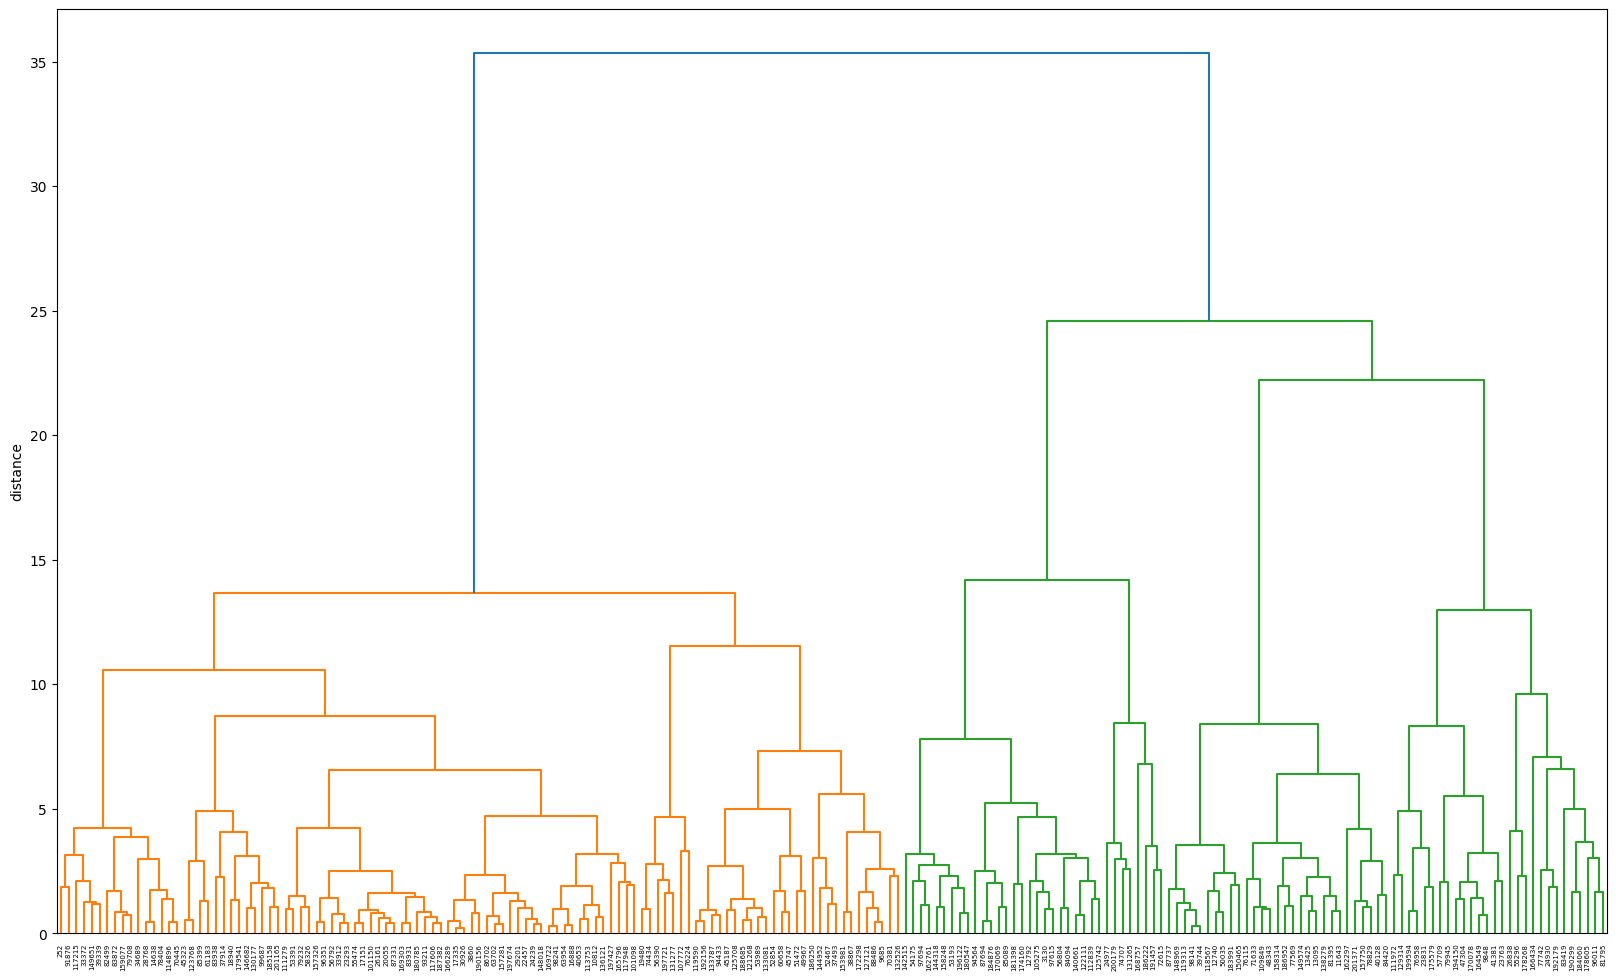

In [103]:
import scipy.cluster.hierarchy as sch

sample = X.sample(200)
Z = sch.linkage(sample, method='ward')

fig, ax1 = plt.subplots(figsize=(20, 12))
sch.dendrogram(Z, labels=sample.index, ax=ax1)
plt.xticks(rotation=90)
ax1.set_ylabel('distance')
plt.show()

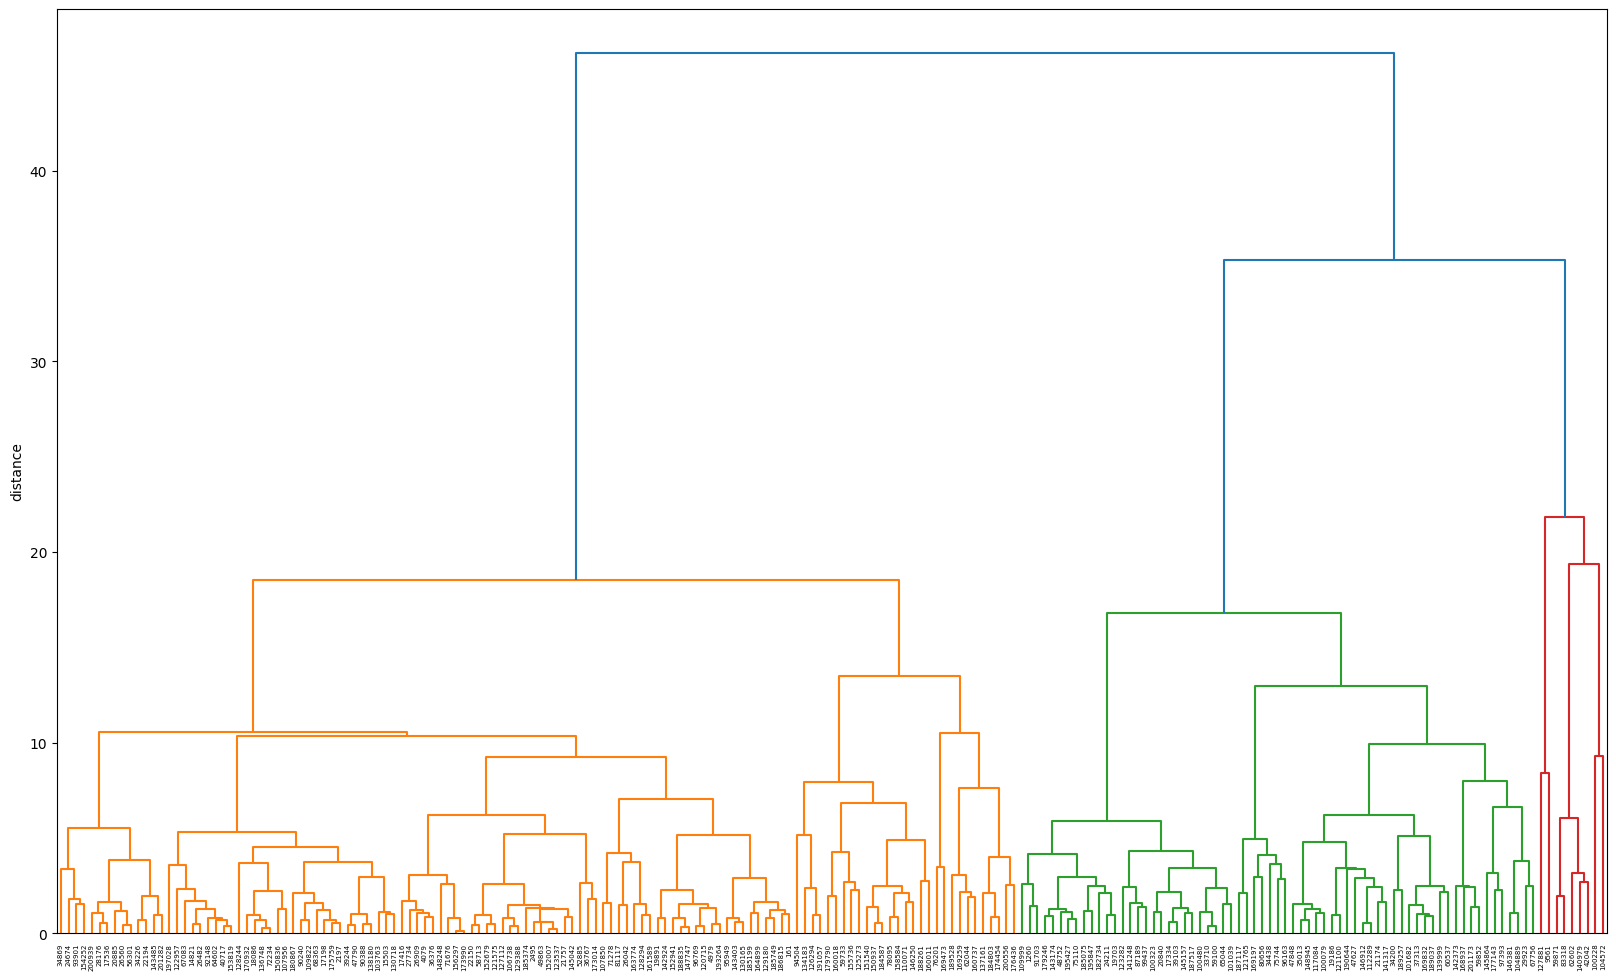

In [104]:
import scipy.cluster.hierarchy as sch

sample = X.sample(200)
Z = sch.linkage(sample, method='ward')

fig, ax2 = plt.subplots(figsize=(20, 12))
sch.dendrogram(Z, labels=sample.index, ax=ax2)
plt.xticks(rotation=90)
ax2.set_ylabel('distance')
plt.show()

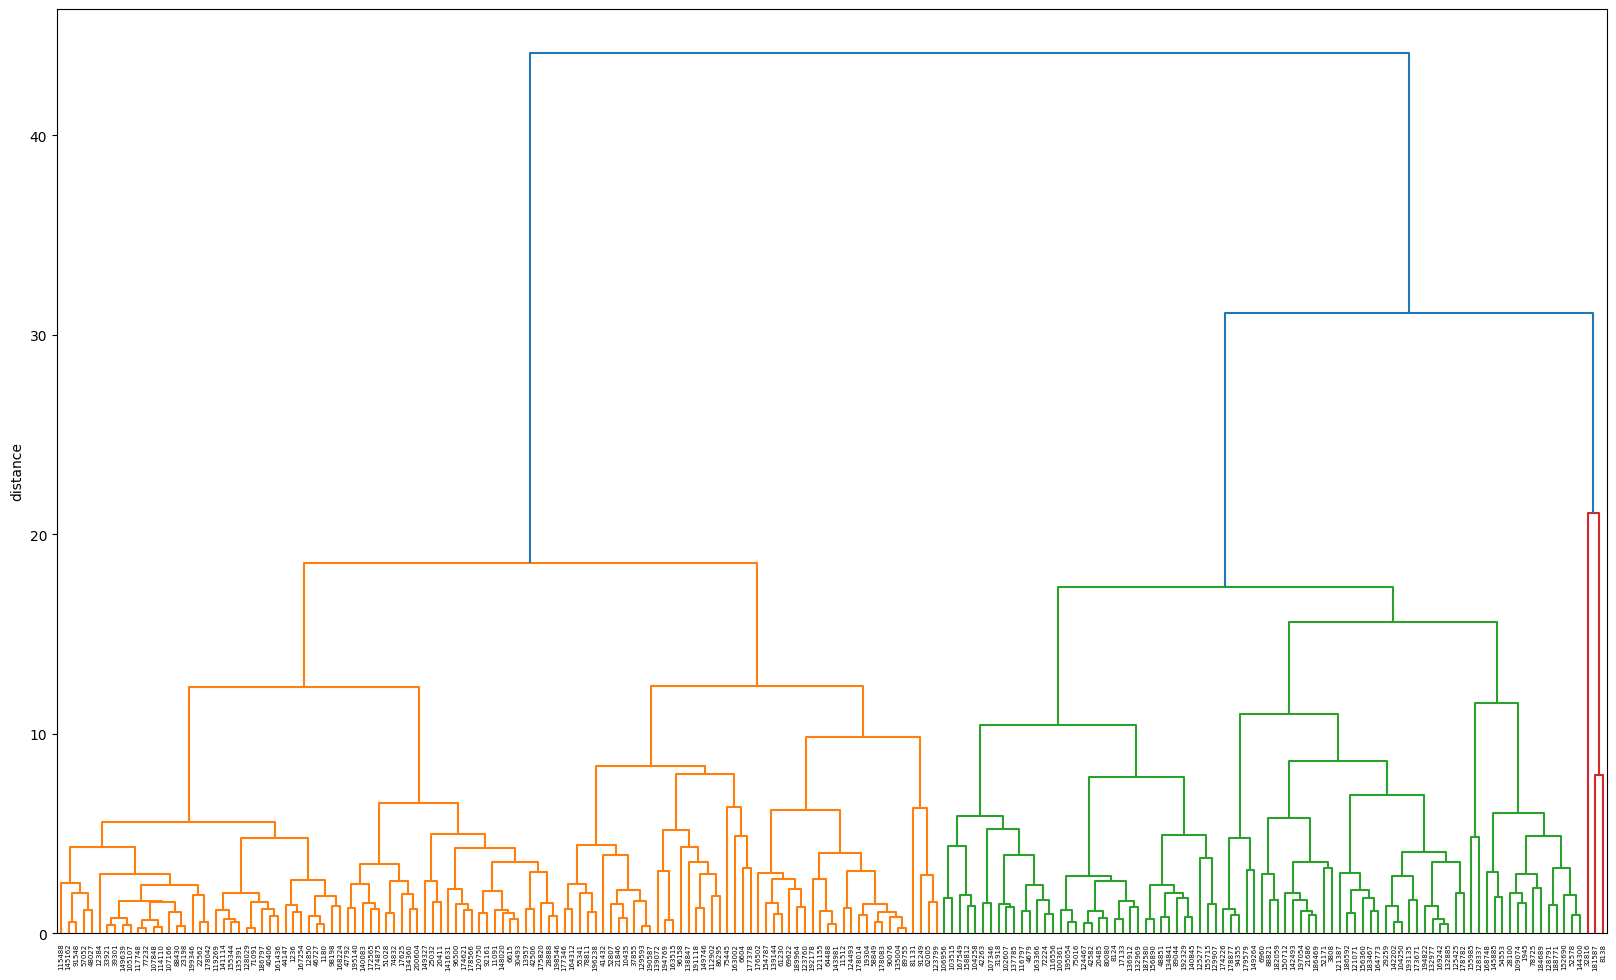

In [105]:
import scipy.cluster.hierarchy as sch

sample = X.sample(200)
Z = sch.linkage(sample, method='ward')

fig, ax3 = plt.subplots(figsize=(20, 12))
sch.dendrogram(Z, labels=sample.index, ax=ax3)
plt.xticks(rotation=90)
ax3.set_ylabel('distance')
plt.show()

* Based on dendrogram, we can observe there are 3 clusters in the data based on similarity
#### Further checking appropriate number of clusters using Elbow Method using k-Means clustering :

## Kmeans clustering

In [106]:
pipe_knn = Pipeline([('scaler', StandardScaler()), ('knn_imputer',  KNNImputer(n_neighbors=2, weights="uniform"))])

In [107]:
pipe_knn_5 = Pipeline([('scaler', StandardScaler()), ('knn_imputer',  KNNImputer(n_neighbors=5, weights="uniform"))])

In [108]:
pipe = Pipeline([('scaler', StandardScaler()), ('simple_imputer',  SimpleImputer(missing_values=np.nan, strategy='mean'))])

In [109]:
pipe_knn_pca = Pipeline([('scaler', StandardScaler()), ('knn_imputer',  KNNImputer(n_neighbors=2, weights="uniform")),('pca',PCA(n_components=8))])

In [110]:
pipe_unscaled = Pipeline([('knn_imputer',  KNNImputer(n_neighbors=5, weights="uniform"))])

## Finding optimal num of clusters using Elbow method

Running for  KNN Immputation


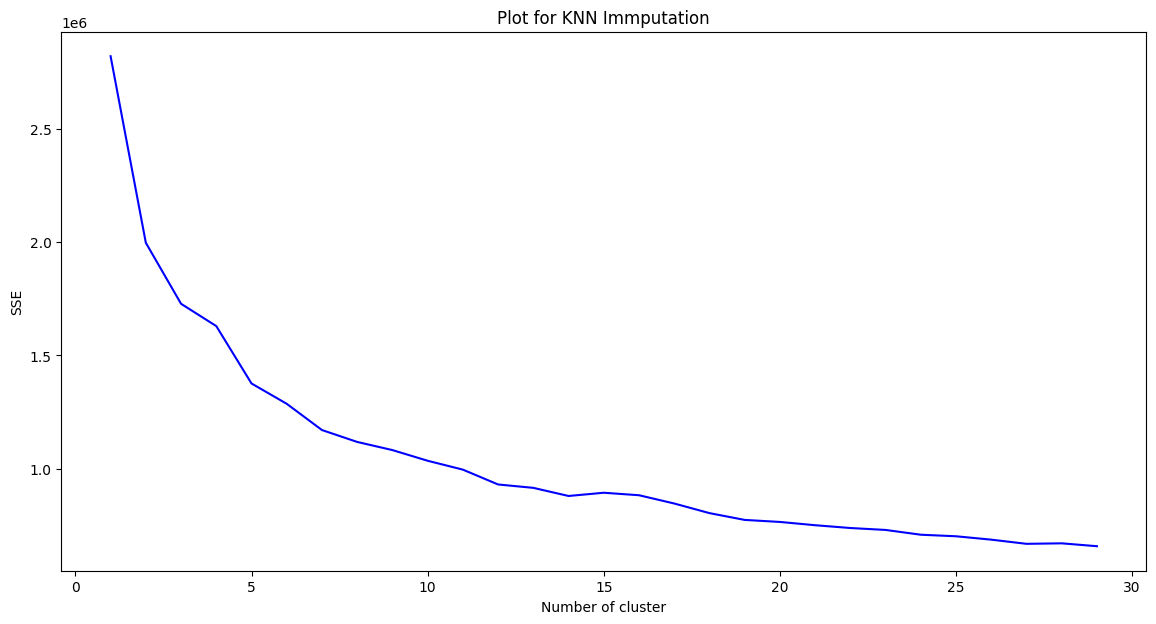

Running for  KNN Imputation with (default) 5 neighbours


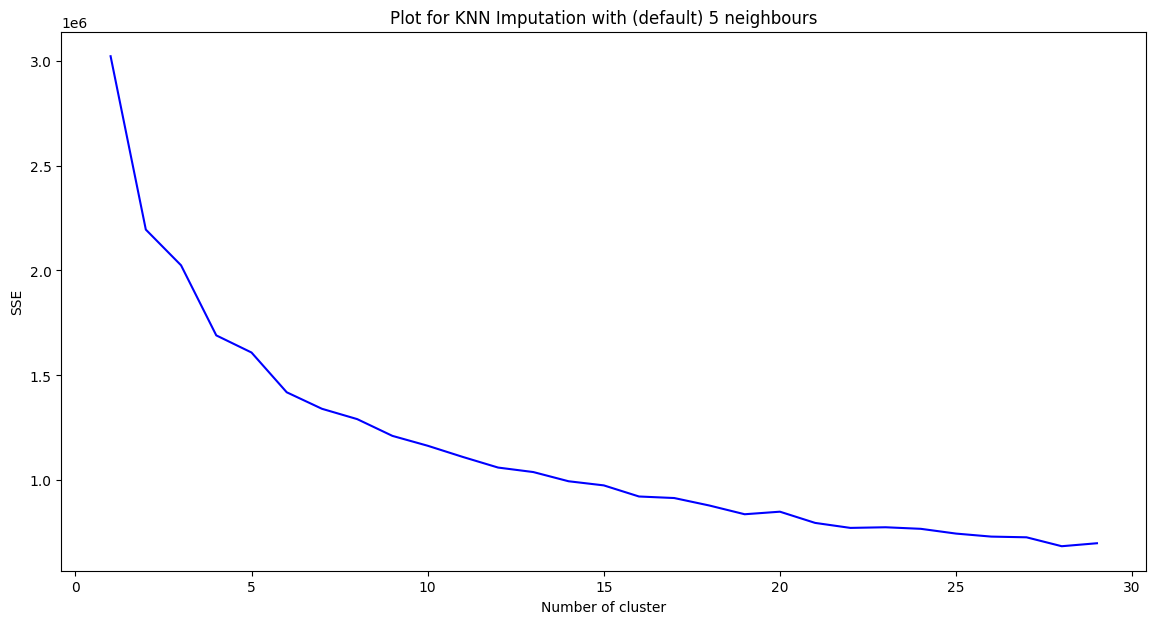

Running for  Mean Imputation 


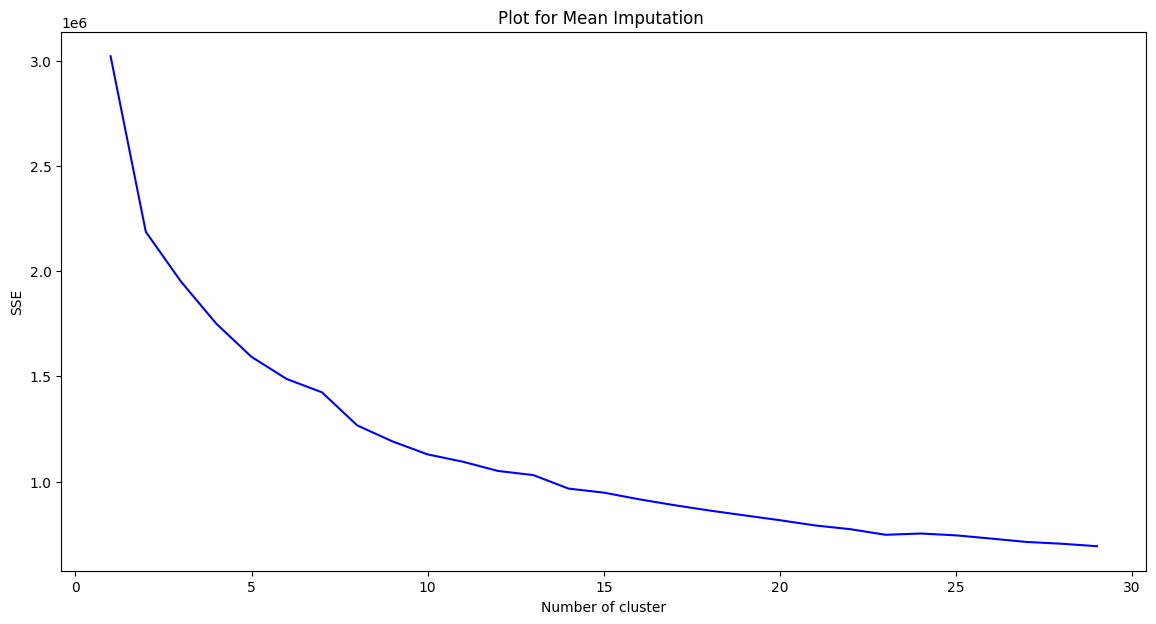

Running for  KNN Immputation + PCA


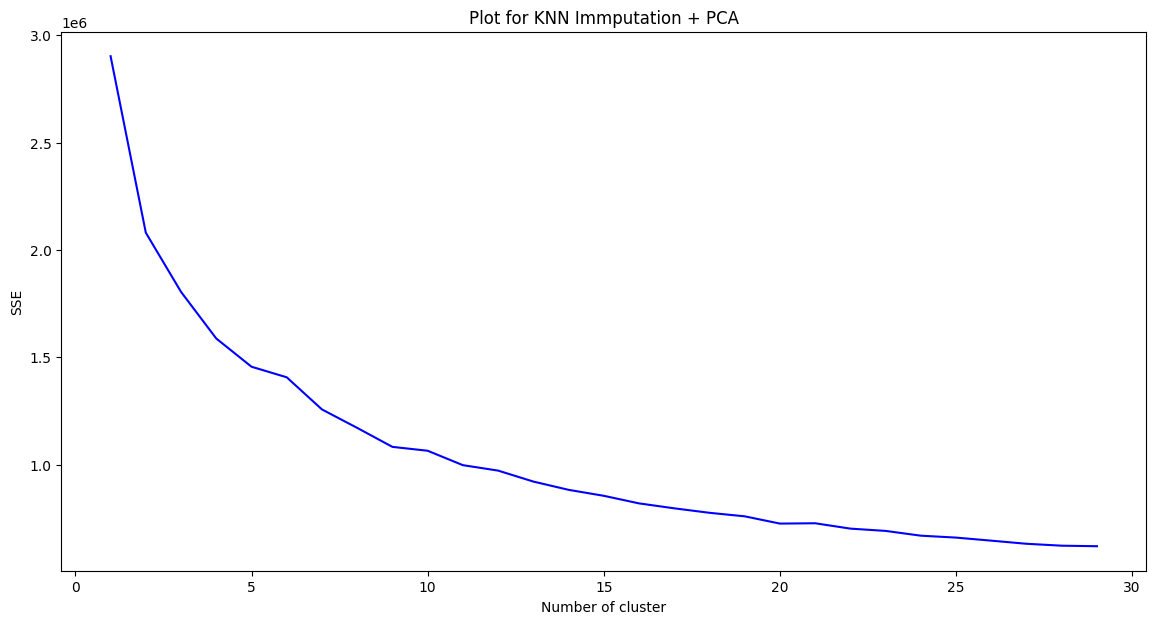

Running for  KNN Imputation Unscaled data


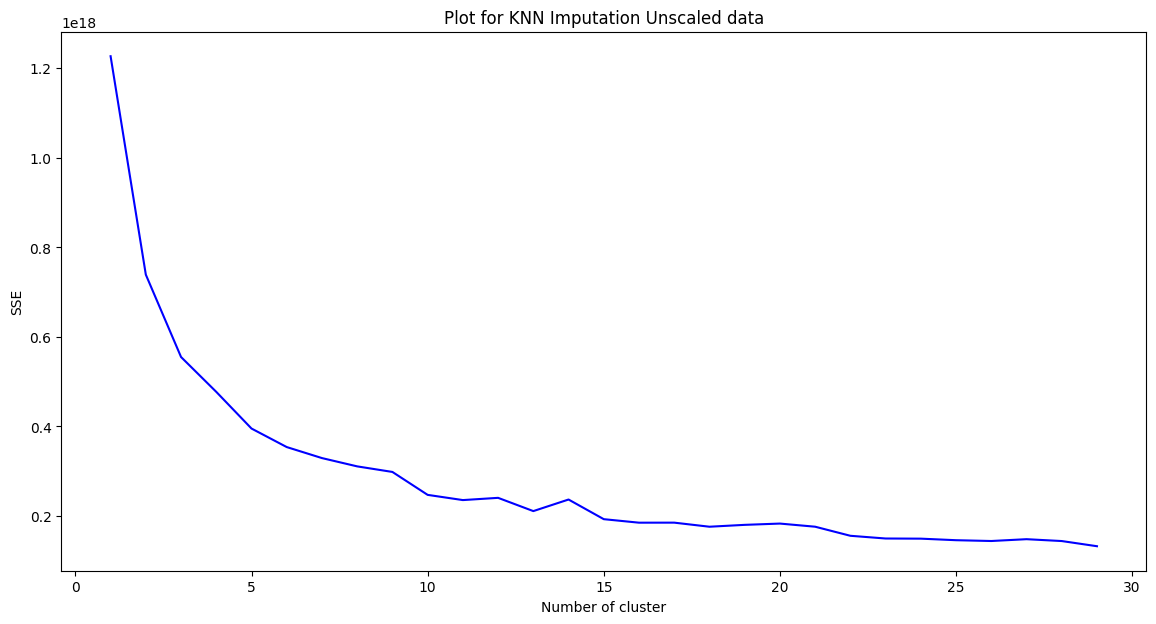

In [111]:
for name,pipeline in [('KNN Immputation',pipe_knn),('KNN Imputation with (default) 5 neighbours',pipe_knn_5),('Mean Imputation ',pipe),
                      ('KNN Immputation + PCA', pipe_knn_pca),('KNN Imputation Unscaled data',pipe_unscaled )]:

    X = pipeline.fit_transform(datatmp)
    X = pd.DataFrame(X)
    if "PCA" not in name :
        X.columns= datatmp.columns

    sse = {}
    print("Running for ",name)
    for k in range(1, 30):
        kmeans = MiniBatchKMeans(init="k-means++",n_clusters=k,
                              random_state=0).fit(X)
        label = kmeans.labels_
        datatmp["clusters"] = label
        sse[k] = kmeans.inertia_ 


    plt.figure(figsize=(14,7))
    plt.plot(list(sse.keys()), list(sse.values()),'b-',label='Sum of squared error')
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    plt.title("Plot for "+name)
    plt.show()

| Model     | N_clusters |
|----------|-----------------|
| KNN Immputation  | 16  |
| KNN Imputation with (default) 5 neighbours    | 20 |
| Mean Imputation      | 25 |
| KNN Immputation + PCA | 21 |
| KNN Imputation Unscaled data | 5 |

* Number of clusters is around 18-20 for scaled data, while around 5 for unscaled data

In [112]:
for i in range(1,10):
    k = 4

    kM = KMeans(n_clusters=k,
               random_state=654)
    y_pred = kM.fit_predict(X)

In [113]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]

inertias = [model.inertia_ for model in kmeans_per_k]
inertias

[1.2270254261284096e+18,
 7.387574640506063e+17,
 5.532265700854374e+17,
 4.637107637866577e+17,
 3.9211306753527846e+17,
 3.5060402966441926e+17,
 3.126052869164911e+17,
 2.8600457163032083e+17,
 2.6300352325099155e+17]

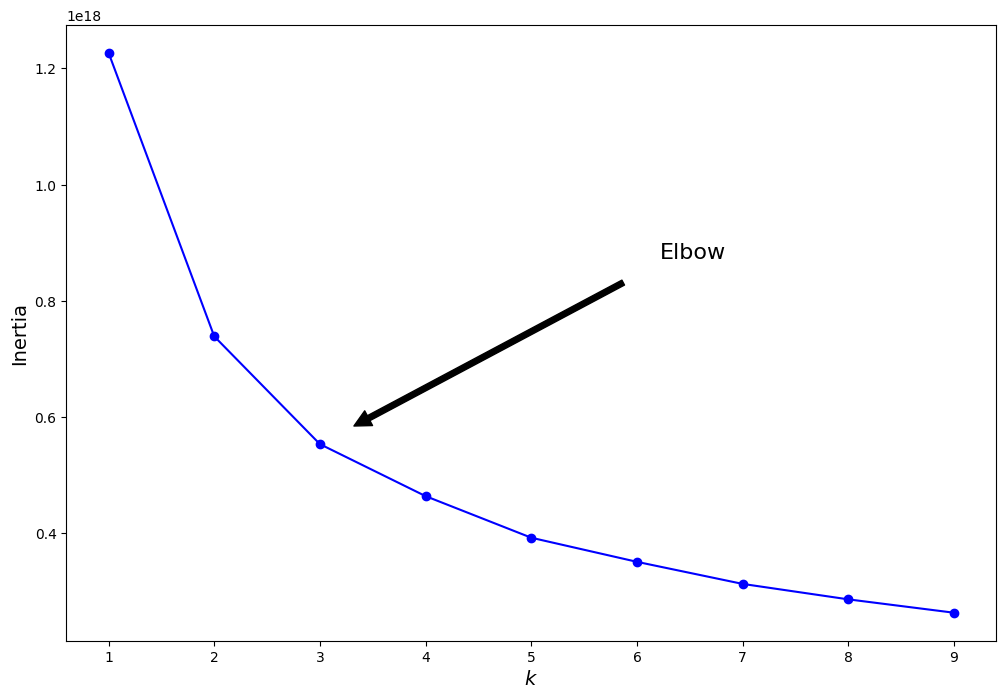

In [114]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(3, inertias[2]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.show()

In [115]:
clusters = pd.DataFrame(X, columns=X.columns)
clusters['label'] = kM.labels_
clusters.sample(5)

,orgyear,ctc,ctc_updated_year,years_of_experience,mean ctc,Designation,mean2 ctc,Class,mean3 ctc,Tier,diff_desig,diff_class,diff_tier,ctc_log,clusters,label
171635,2012.0,742000.0,2016.0,12.0,1.794000e+06,3.0,1.715750e+06,3.0,1.786886e+06,3.0,-1.052000e+06,-973749.937500,-1.044886e+06,19.501060,12.0,0
5086,2014.0,1000000.0,2021.0,10.0,9.300000e+05,1.0,9.190000e+05,1.0,1.044038e+06,3.0,7.000000e+04,81000.020000,-4.403844e+04,19.931569,6.0,1
93005,2022.0,300000.0,2022.0,2.0,5.250000e+05,3.0,6.027020e+05,3.0,6.124847e+05,3.0,-2.250000e+05,-302701.961564,-3.124847e+05,18.194603,24.0,1
89476,2020.0,400000.0,2021.0,4.0,4.438887e+05,3.0,6.913090e+05,3.0,7.547604e+05,3.0,-4.388872e+04,-291308.960674,-3.547604e+05,18.609640,24.0,1
69628,2012.0,2111000.0,2017.0,12.0,2.076200e+06,1.0,1.863870e+06,1.0,1.953500e+06,1.0,3.480000e+04,247130.454545,1.575000e+05,21.009495,20.0,0


## EDA after Clustering

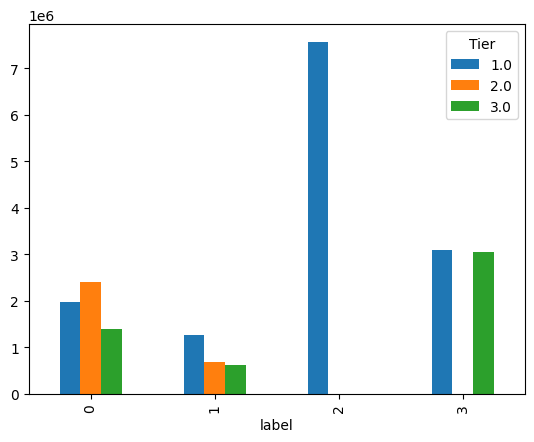

In [116]:
pd.crosstab(index = clusters["label"],
    columns = clusters["Tier"],values=clusters["ctc"],aggfunc= np.mean
       ).plot(kind = "bar")
plt.show()

* Based on k-Means Clustering algorithm output , as well as manual clustering , learners from tier1 company receiving very high CTC.


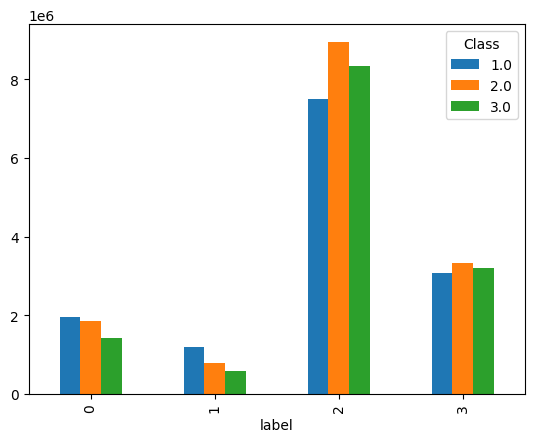

In [117]:
pd.crosstab(index = clusters["label"],
    columns = clusters["Class"],values=clusters["ctc"],aggfunc= np.mean
       ).plot(kind = "bar")
plt.show()

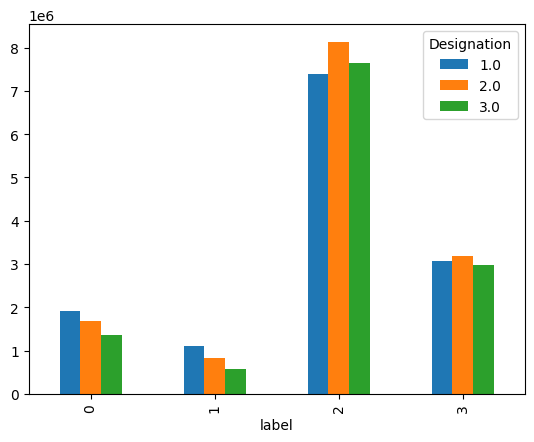

In [118]:
pd.crosstab(index = clusters["label"],
    columns = clusters["Designation"],
            values=clusters["ctc"],aggfunc= np.mean
       ).plot(kind = "bar")
plt.show()

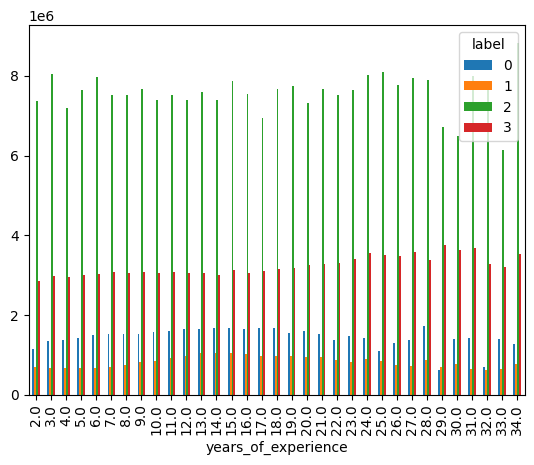

In [119]:
pd.crosstab(columns = clusters["label"],
    index = clusters["years_of_experience"],
            values=clusters["ctc"],aggfunc= np.mean
       ).plot(kind = "bar")
plt.show()

* Cluster label 2, are those learners who are very very experienced.

In [120]:
clusters.label.value_counts(normalize=True)*100

1    68.080015
0    16.797327
3    13.748864
2     1.373794
Name: label, dtype: float64

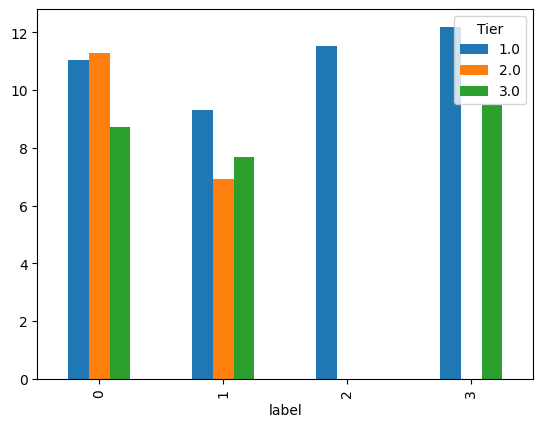

In [121]:
# years_of_experience per each cluster group of learners
pd.crosstab(index = clusters["label"],
    columns = clusters["Tier"],
            values=clusters["years_of_experience"],
            aggfunc=np.mean
       ).plot(kind = "bar")
plt.show()

## Statistical Summury based on Each Cluster

In [122]:
clusters.groupby("label").describe()[["ctc","Class","Tier","years_of_experience"]].T

label                                 0             1             2  \
ctc                 count  3.383200e+04  1.371220e+05  2.767000e+03   
                    mean   1.539786e+06  7.713451e+05  7.564227e+06   
                    std    6.210890e+05  4.148623e+05  1.942410e+06   
                    min    3.955000e+04  3.800000e+04  4.400000e+06   
                    25%    1.200000e+06  4.500000e+05  6.000000e+06   
                    50%    1.600000e+06  7.000000e+05  7.000000e+06   
                    75%    2.000000e+06  1.000000e+06  9.000000e+06   
                    max    4.000000e+06  2.200000e+06  1.250000e+07   
Class               count  3.383200e+04  1.371220e+05  2.767000e+03   
                    mean   2.578092e+00  2.376577e+00  1.043730e+00   
                    std    7.785757e-01  8.921285e-01  2.114823e-01   
                    min    1.000000e+00  1.000000e+00  1.000000e+00   
                    25%    3.000000e+00  1.000000e+00  1.000000e+00   
                    50%    3.000000e+00  3.000000e+00  1.000000e+00   
                    75%    3.000000e+00  3.000000e+00  1.000000e+00   
                    max    3.000000e+00  3.000000e+00  3.000000e+00   
Tier                count  3.383200e+04  1.371220e+05  2.767000e+03   
                    mean   2.529233e+00  2.504609e+00  1.000000e+00   
                    std    8.481931e-01  8.630596e-01  0.000000e+00   
                    min    1.000000e+00  1.000000e+00  1.000000e+00   
                    25%    3.000000e+00  3.000000e+00  1.000000e+00   
                    50%    3.000000e+00  3.000000e+00  1.000000e+00   
                    75%    3.000000e+00  3.000000e+00  1.000000e+00   
                    max    3.000000e+00  3.000000e+00  1.000000e+00   
years_of_experience count  3.383200e+04  1.371220e+05  2.767000e+03   
                    mean   9.260877e+00  8.089395e+00  1.153993e+01   
                    std    3.832685e+00  3.600889e+00  5.868754e+00   
                    min    2.000000e+00  2.000000e+00  2.000000e+00   
                    25%    6.000000e+00  6.000000e+00  7.000000e+00   
                    50%    9.000000e+00  7.000000e+00  1.000000e+01   
                    75%    1.100000e+01  1.000000e+01  1.500000e+01   
                    max    3.400000e+01  3.400000e+01  3.400000e+01   

label                                 3  
ctc                 count  2.769200e+04  
                    mean   3.094949e+06  
                    std    8.840100e+05  
                    min    1.700000e+06  
                    25%    2.400000e+06  
                    50%    2.960000e+06  
                    75%    3.600000e+06  
                    max    7.500000e+06  
Class               count  2.769200e+04  
                    mean   1.139715e+00  
                    std    4.376737e-01  
                    min    1.000000e+00  
                    25%    1.000000e+00  
                    50%    1.000000e+00  
                    75%    1.000000e+00  
                    max    3.000000e+00  
Tier                count  2.769200e+04  
                    mean   1.005778e+00  
                    std    1.073439e-01  
                    min    1.000000e+00  
                    25%    1.000000e+00  
                    50%    1.000000e+00  
                    75%    1.000000e+00  
                    max    3.000000e+00  
years_of_experience count  2.769200e+04  
                    mean   1.218211e+01  
                    std    5.600577e+00  
                    min    2.000000e+00  
                    25%    8.000000e+00  
                    50%    1.100000e+01  
                    75%    1.500000e+01  
                    max    3.400000e+01

## Insights

* Top Paying job titles include full stack engineer', 'iOS engineer', 'data analyst', 'qi engineer', 'engineering leadership', 'data scientist', 'sdet', 'support engineer', 'security leadership', 'devops engineer'.
* Among top paying companies, salary for these is getting lesser in recent years, Goldmaan Sachs, Tata Consultancy Services, Samsung Electronics, VMware, Dell,  Dbs Bank, Hsbc software development India and GE
* Among Top paying companies mean salary for these company is increasing every year, Amazon, Microsoft and Huawei Technologies
* Avg. CTC seems to be decreasing with year.
* 1017 unique job positions are there in the dataset.
* 857 unique job positions are there in the dataset after pre-processing strings.
* Number of clusters is around 18-20 for scaled data, while around 5 for unscaled data.
* Majority number of Tier is 3.
* As compare to other Cluster label 1 is the high value.
* Based on k-Means Clustering algorithm output , as well as manual clustering , learners from tier1 company receiving very high CTC.
* Cluster label 2, are those learners who are very very experienced.
* Based on dendrogram , we can observe there are 3 clusters in the data based on similarity.
## Recommendations

* Freshers who want to work on technical side should look for roles related to Backend Engineer, SDET, QA engineer, Data Scientist, Android Engineer, Full stack engineer to get good salaries as experience increases.
* Freshers who want best CTC should aim for companies like 'Cisco', 'Intel Technology India Pvt Ltd', 'Amazon', 'Walmart Labs', 'Symantec', 'Schneider Electric India', 'Morgan Stanley', 'Ericsson RD Bangalore' and 'Samsung Electronics'.